In [1]:
%matplotlib inline

import numpy as np
import collections
from collections import OrderedDict, Counter, defaultdict
import pandas as pd

import Bio
from Bio import SeqIO

import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show 
import matplotlib.patches as patches    
from matplotlib import colors


import glob

import subprocess
from subprocess import call

import re

import pickle

from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

from scipy import stats


from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

/home/alla/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def prepare_data_for_trips2(meta, file_counts, metadata_pc_g25, 
                           tr_id, gene, l, p, fraq, cds, 
                           predicted_ext_start=False, figsize=(20, 10),
                           xlims='full', zeros=True, name='test.png', linew=9):
    
    f = pd.read_csv(file_counts)
    f.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq']
    
    atgs_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}
    stop_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}

    for pos in f.Position.tolist():
        codon = ''.join(f.Sequence.tolist()[(pos-1):(pos-1+3)])
        if codon == 'ATG':
            if pos % 3 == 0:
                atgs_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                atgs_pos['frame_1'].append(pos)
            else:
                atgs_pos['frame_2'].append(pos)
            
        elif (codon == 'TGA') | (codon == 'TAA') | (codon == 'TAG'):
            if pos % 3 == 0:
                stop_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                stop_pos['frame_1'].append(pos)
            else:
                stop_pos['frame_2'].append(pos)
        else:
            continue     
            
    # add CDS borders
    cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
    cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos + 1
    cds_start_codon = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_codon
    
    if xlims == 'ext':
        xlim1 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1
        xlim2 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1 + 50*3
    elif len(xlims) == 2:
        xlim1 = xlims[0]
        xlim2 = xlims[1]
    else: # full transcript
        xlim1 = 0
        xlim2 = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    
    d = {}
    
    d['cds_stop_pos'] = cds_stop_pos
    d['cds_start_pos'] = cds_start_pos
    d['cds_start_codon'] = cds_start_codon
    d['f'] = f
    d['stop_pos'] = stop_pos
    d['atgs_pos'] = atgs_pos
    d['xlims'] = (xlim1, xlim2)
    d['predicted_ext_start'] = predicted_ext_start
    d['l'] = l
    d['p'] = p
    d['figsize'] = figsize
    d['fraq'] = fraq
    d['cds'] = cds
    d['name'] = tr_id+'_'+gene
    d['zeros'] = zeros
    d['linew'] = linew
    
    return d


def trips_full2(d, name='test', font1=38, font2=45):
    
    l = d['l']
    p = d['p']
    f = d['f'] # dict with frames 
    atgs_pos = d['atgs_pos']
    stop_pos = d['stop_pos']
    cds_start_pos = d['cds_start_pos']
    cds_stop_pos = d['cds_stop_pos']
    figsize = d['figsize']
    xlims = d['xlims']
    fraq = d['fraq']
    cds = d['cds']
    name = d['name']
    zeros = d['zeros']
    linewidth = d['linew'] 
    
    fig, axes = plt.subplots(5, 1, figsize = figsize, 
                             gridspec_kw={'height_ratios':[10,1.5,1,1,1]}, sharex=True, sharey=False, )

    main_plot = axes[0]
    #cds = axes[1]
    orfs = axes[1]
    red = axes[2]
    green = axes[3]
    blue = axes[4]

    # x 
    main_plot.set_xlim(f.Position.min(), f.Position.max()+1)

    # y
    
    if xlims is not False:
        f1 = f[xlims[0]:xlims[1]]
        max_height = np.max([np.max(f1.Frame1.tolist()), np.max(f1.Frame2.tolist()), np.max(f1.Frame3.tolist())])
        print (max_height)
    else:
        max_height = np.max([np.max(f.Frame1.tolist()), np.max(f.Frame2.tolist()), np.max(f.Frame3.tolist())])
        print (max_height)
        
    #### ????? why they dissappear????? ######    
    main_plot.set_ylim(0, max_height+max_height/l)
    main_plot.set_yticks(np.arange(0, max_height+max_height/l, p))
    main_plot.set_yticklabels(np.arange(0, max_height+max_height/l, p, dtype=np.int64), fontsize=font1)
    
    # print (f[125:150])

    # #frame 1 = red, frame2 = green, frame3 = blue
    if zeros == True:
        main_plot.plot(f.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
    else:
        # delete zeros 
        t = f[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = f[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = f[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        main_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
        
        
        
    red.set_facecolor('coral')
    green.set_facecolor('mediumseagreen')
    blue.set_facecolor('cornflowerblue')
    #cds.set_facecolor('lightgrey')

    #blue.set_xticks(np.arange(0, f.Position.max(), 50))
    #blue.set_xticklabels(np.arange(0, f.Position.max(), 50), fontsize=45)

    red.set_yticklabels(())
    green.set_yticklabels(())
    blue.set_yticklabels(())
    #cds.set_yticklabels(())
    orfs.set_yticklabels(())
    
    

    blue.set_ylabel('f2', fontsize=font1)#, rotation = 0)
    red.set_ylabel('f0', fontsize=font1)#, rotation = 0)
    green.set_ylabel('f1', fontsize=font1)#, rotation = 0)
    #cds.set_ylabel('cds', fontsize=35)#, rotation = 0)
    orfs.set_ylabel('orf', fontsize=font1)#, rotation = 0)

    for frame, pos_li in atgs_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
            
    for frame, pos_li in stop_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
            
                    
    # add start of annotated CDS
    main_plot.vlines(cds_stop_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    main_plot.vlines(cds_start_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.text(x = cds_stop_pos-100, y = max_height+max_height/10, s = 'cds stop', fontsize=39)
    #main_plot.text(x = cds_start_pos-10, y = max_height+0.1, s = 'cds start', fontsize=39)


    # add rectangle = CDS
    #if cds is True:
        #rect = patches.Rectangle((cds_start_pos, 0),cds_stop_pos-cds_start_pos,
                         #1,linewidth=1,edgecolor='r',facecolor='lightgrey')
        #cds.add_patch(rect)

        # add non-AUG - cds_start_pos
        #cds.text(x = cds_start_pos, y = 0.3, s = 'AUG', fontsize=38)

    
    # add rectangle = extended CDS
    xlims = d['xlims']
    predicted_ext_start = d['predicted_ext_start']
    if xlims is not False:
        if predicted_ext_start is not False:
            Nst = int(predicted_ext_start.split('_')[0])
            codon_name = predicted_ext_start.split('_')[1]
            N2 = cds_stop_pos
            rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            orfs.add_patch(rect)
        
            orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)

    
    blue.set_xticks(range(f.Position.min(), f.Position.max()+1, fraq))       
    blue.set_xticklabels(range(f.Position.min(), f.Position.max()+1, fraq), fontsize=font1)
    
    print (f.Position.min())
    
    
    if xlims is not False:    
        plt.xlim(xlims[0], xlims[1])
        
        
    main_plot.set_title(name, fontsize=font2)
    plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)
    
    plt.savefig('plots/'+name+'.png', dpi = 300, bbox_inches = 'tight')
    

In [3]:
# open metadata with scores and metrics
meta = pd.read_csv('tmp_res/METADATA_CURRENT.txt', sep='\t')

# gencode 25
metadata_pc_g25 = pd.read_csv('tmp_res/metadata_pc_g25.txt', sep='\t')


P_Set = pd.read_csv('tmp_res/SET1.txt', sep='\t')

R_Set = pd.read_csv('tmp_res/SET2.txt', sep='\t')

R_Set['pos_of_codon'] = [int(x.split('; ')[1].split('-')[0])-1 for x in R_Set.Riboseq_Summary.tolist()]

R_Set['codon'] = [x.split('; ')[0] for x in R_Set.Riboseq_Summary.tolist()]

R_Set[0:2]

,tr_id,gene,N_term_start1,N_term_end1,len_codons,global_coo_50_and_less,strand,global_coo_primary,PhyloCSF120score,number_of_records,ovlp,Riboseq_Summary,Coverage_value_ext,Proteomics_count_ext,tag,transcript_type,CDS_ratio,pos_of_codon,codon
0,ENST00000379389.4,ISG15,1,151,50.0,chr1:1013424-1013573,+,chr1:1013424-1013573,-2443.9971,111,0;0;0,ATC; 98-152; Rank: 288; cov: 53.85,53.846154,0.0,"basic,appris_principal_1,CCDS",protein_coding,0.327240,97,ATC
1,ENST00000349431.10,UBE2J2,28,220,64.0,chr1:1273666-1273815,-,chr1:1273666-1273857,-1285.8186,78,0;0;0,ACG; 173-221; Rank: 328; cov: 90.91,90.909091,0.0,"basic,appris_principal_1,CCDS",protein_coding,0.762814,172,ACG


# Genomic coordinates for genes ready for annotation 

In [8]:
f = pd.read_csv('data/Genes_for_gencode_annotation.txt', sep='\t')
f.columns

Index(['Gene', 'RiboSET', 'PhyloSET', 'Jon's list ', 'tr_id in gencode25',
       'new_cds_start ', 'cds_stop', 'codon', 'mouse gene ', 'mouse tr_id',
       'mouse_new_cds_start ', 'mouse_cds_stop', 'mouse_codon',
       'Alla's comments (mouse)', 'Alla comments (human)',
       'Jon comments (human)'],
      dtype='object')

In [12]:
metadata_pc_g25['tr_id in gencode25'] = [x.split('.')[0] for x in metadata_pc_g25['tr_id'].tolist()]

f[f['new_cds_start '] != '?'][['Gene', 'tr_id in gencode25', 'new_cds_start ', 'cds_stop']].merge(metadata_pc_g25[['tr_id', 'tr_id in gencode25']],
                                                                    on='tr_id in gencode25', how='inner').to_csv('tmp_res/human_genes_for_annotation_in_gencode_local_coo.txt',
                                                                                                                sep='\t', index=False)

In [ ]:
# tmp_res/human_genes_for_annotation_in_gencode_global_coo.txt

In [73]:
def prepare_global_coo(path_to_file_with_global_coo, colname):
    global_coo_g25 = pd.read_csv(path_to_file_with_global_coo, sep='\t')
    global_coo_g25_f = global_coo_g25[global_coo_g25['hit'] == True]
    global_coo_g25_f = global_coo_g25_f.sort_values(by=['seqnames', 'start'])
    global_coo_g25_f['global_coo'] = global_coo_g25_f['seqnames']+':'+global_coo_g25_f['start'].astype(str) +'-'+global_coo_g25_f['end'].astype(str)
    global_coo_g25_f = global_coo_g25_f[['group_name', 'strand', 'global_coo']].groupby(['group_name', 'strand']).agg('+'.join).reset_index()
    global_coo_g25_f.columns = ['tr_id', 'strand', colname]
    return global_coo_g25_f

In [74]:
global_df = prepare_global_coo(path_to_file_with_global_coo='tmp_res/human_genes_for_annotation_in_gencode_global_coo.txt',
                                   colname = 'global_coo')


ann_df = f[f['new_cds_start '] != '?'][['Gene', 'tr_id in gencode25', 'new_cds_start ', 'cds_stop', 'codon']].merge(metadata_pc_g25[['tr_id', 'tr_id in gencode25']],
                                                                    on='tr_id in gencode25', how='inner').merge(global_df, on='tr_id', how='inner')

In [75]:
ann_df[0:4]

,Gene,tr_id in gencode25,new_cds_start,cds_stop,codon,tr_id,strand,global_coo
0,SFPQ,ENST00000357214,36,2223,GTG,ENST00000357214.5,-,chr1:35184456-35184593+chr1:35187001-35187122+...
1,VANGL2,ENST00000368061,331,2040,ATA,ENST00000368061.2,+,chr1:160415694-160415908+chr1:160416062-160416...
2,CCDC8,ENST00000307522,552,2391,CTG,ENST00000307522.3,-,chr19:46411194-46413020
3,USP27X,ENST00000621775,51,1677,CTG,ENST00000621775.1,+,chrX:49879999-49881624


In [76]:
i = 0

print (ann_df.iloc[i].Gene, ann_df.iloc[i].codon)
print ()
print (ann_df.iloc[i].global_coo, ann_df.iloc[i].strand)

SFPQ GTG

chr1:35184456-35184593+chr1:35187001-35187122+chr1:35187203-35187251+chr1:35187973-35188090+chr1:35189003-35189087+chr1:35189186-35189382+chr1:35190498-35190593+chr1:35190694-35190995+chr1:35191341-35191529+chr1:35192222-35193112 -


## VANGL2: start - 1

In [77]:
i = 1

print (ann_df.iloc[i].Gene, ann_df.iloc[i].codon)
print ()
print (ann_df.iloc[i].global_coo, ann_df.iloc[i].strand)

VANGL2 ATA

chr1:160415694-160415908+chr1:160416062-160416182+chr1:160419002-160419609+chr1:160420411-160420547+chr1:160421052-160421187+chr1:160424052-160424283+chr1:160425118-160425378 +


## CCDC8 in genome CCDC8 instead of CTG it's CCA so it's next-next ATC 

In [78]:
i = 2

print (ann_df.iloc[i].tr_id, ann_df.iloc[i].Gene, ann_df.iloc[i].codon)
print ()
print (ann_df.iloc[i].global_coo, ann_df.iloc[i].strand)

ENST00000307522.3 CCDC8 CTG

chr19:46411194-46413020 -


In [79]:
metadata_pc_g25[metadata_pc_g25['tr_id'] == 'ENST00000307522.3'].iloc[0].transcript_seq[564:570]

'CTGGAG'

In [80]:
i = 3

print (ann_df.iloc[i].tr_id, ann_df.iloc[i].Gene, ann_df.iloc[i].codon)
print ()
print (ann_df.iloc[i].global_coo, ann_df.iloc[i].strand)

ENST00000621775.1 USP27X CTG

chrX:49879999-49881624 +


In [81]:
i = 4

print (ann_df.iloc[i].tr_id, ann_df.iloc[i].Gene, ann_df.iloc[i].codon)
print ()
print (ann_df.iloc[i].global_coo, ann_df.iloc[i].strand)

ENST00000380861.8 WWC3 CTG

chrX:10015761-10015858+chrX:10063445-10063554+chrX:10067287-10067490+chrX:10078799-10078875+chrX:10079725-10079804+chrX:10090771-10090900+chrX:10094132-10094281+chrX:10098506-10098579+chrX:10109778-10110020+chrX:10116418-10116507+chrX:10117124-10117689+chrX:10122619-10122739+chrX:10124265-10124339+chrX:10125024-10125110+chrX:10126114-10126306+chrX:10127988-10128161+chrX:10128557-10128708+chrX:10129956-10130121+chrX:10134432-10134596+chrX:10136633-10136725+chrX:10138709-10138936+chrX:10139413-10139540+chrX:10141435-10141501 +


In [82]:
i = 5

print (ann_df.iloc[i].tr_id, ann_df.iloc[i].Gene, ann_df.iloc[i].codon)
print ()
print (ann_df.iloc[i].global_coo, ann_df.iloc[i].strand)

ENST00000455833.6 IFFO2 CTG

chr1:18908561-18908666+chr1:18910342-18910472+chr1:18911384-18911476+chr1:18911963-18912083+chr1:18916903-18917042+chr1:18918362-18918502+chr1:18919678-18919773+chr1:18921061-18921121+chr1:18955668-18956386 -


In [83]:
i = 6

print (ann_df.iloc[i].tr_id, ann_df.iloc[i].Gene, ann_df.iloc[i].codon)
print ()
print (ann_df.iloc[i].global_coo, ann_df.iloc[i].strand)

ENST00000267460.8 PELI2 ACG

chr14:56118490-56118737+chr14:56178335-56178464+chr14:56279676-56279777+chr14:56288437-56288634+chr14:56290268-56290456+chr14:56296600-56297166 +


In [84]:
i = 7

print (ann_df.iloc[i].tr_id, ann_df.iloc[i].Gene, ann_df.iloc[i].codon)
print ()
print (ann_df.iloc[i].global_coo, ann_df.iloc[i].strand)

ENST00000452733.6 CYTH2 GTG

chr19:48469400-48469526+chr19:48470353-48470500+chr19:48470603-48470669+chr19:48472325-48472443+chr19:48473298-48473378+chr19:48473905-48474017+chr19:48474182-48474330+chr19:48474838-48474949+chr19:48478069-48478145+chr19:48478275-48478346+chr19:48478438-48478592+chr19:48479123-48479210 +


In [85]:
i = 8
print (ann_df.iloc[i].tr_id, ann_df.iloc[i].Gene, ann_df.iloc[i].codon)
print ()
print (ann_df.iloc[i].global_coo, ann_df.iloc[i].strand)

ENST00000250113.11 FXR2 GTG

chr17:7591830-7591925+chr17:7592254-7592354+chr17:7592504-7592599+chr17:7592694-7592894+chr17:7592984-7593181+chr17:7593403-7593625+chr17:7593918-7594004+chr17:7594238-7594347+chr17:7594679-7594757+chr17:7595824-7595994+chr17:7601409-7601525+chr17:7602909-7603002+chr17:7603757-7603905+chr17:7604009-7604080+chr17:7605645-7605738+chr17:7606097-7606149+chr17:7614452-7614751 -


In [86]:
i = 9
print (ann_df.iloc[i].tr_id, ann_df.iloc[i].Gene, ann_df.iloc[i].codon)
print ()
print (ann_df.iloc[i].global_coo, ann_df.iloc[i].strand)

ENST00000333762.5 H1FX CTG

chr3:129315261-129316055 -


In [87]:
i = 10
print (ann_df.iloc[i].tr_id, ann_df.iloc[i].Gene, ann_df.iloc[i].codon)
print ()
print (ann_df.iloc[i].global_coo, ann_df.iloc[i].strand)

ENST00000314940.6 HNRNPA0 ATA

chr5:137753149-137754129 -


In [88]:
i = 11
print (ann_df.iloc[i].tr_id, ann_df.iloc[i].Gene, ann_df.iloc[i].codon)
print ()
print (ann_df.iloc[i].global_coo, ann_df.iloc[i].strand)

ENST00000612661.1 MARCKS TTG

chr6:113857710-113857847+chr6:113859683-113860579 +


In [89]:
i = 12
print (ann_df.iloc[i].tr_id, ann_df.iloc[i].Gene, ann_df.iloc[i].codon)
print ()
print (ann_df.iloc[i].global_coo, ann_df.iloc[i].strand)

ENST00000306801.7 RPTOR CTG

chr17:80545576-80545791+chr17:80625691-80625793+chr17:80643728-80643810+chr17:80707841-80707999+chr17:80730560-80730706+chr17:80754010-80754185+chr17:80791450-80791509+chr17:80822201-80822301+chr17:80823079-80823223+chr17:80837922-80837997+chr17:80846473-80846574+chr17:80855464-80855547+chr17:80857790-80857900+chr17:80880415-80880489+chr17:80883419-80883484+chr17:80883781-80883972+chr17:80885008-80885148+chr17:80891720-80891837+chr17:80892729-80892869+chr17:80893707-80893865+chr17:80908811-80908929+chr17:80922724-80922827+chr17:80923490-80923673+chr17:80925370-80925480+chr17:80940496-80940601+chr17:80945667-80945781+chr17:80947227-80947351+chr17:80949443-80949547+chr17:80957624-80957730+chr17:80960078-80960205+chr17:80961394-80961480+chr17:80962461-80962577+chr17:80962928-80963057+chr17:80964262-80964330 +


In [90]:
i = 13
print (ann_df.iloc[i].tr_id, ann_df.iloc[i].Gene, ann_df.iloc[i].codon)
print ()
print (ann_df.iloc[i].global_coo, ann_df.iloc[i].strand)

ENST00000398888.6 USP19 ATA

chr3:49108958-49109185+chr3:49110184-49110362+chr3:49110444-49110604+chr3:49110711-49110863+chr3:49110950-49111166+chr3:49111255-49111365+chr3:49111500-49111813+chr3:49111911-49112048+chr3:49112284-49112402+chr3:49112489-49112629+chr3:49113992-49114093+chr3:49114174-49114284+chr3:49114763-49114873+chr3:49114959-49115117+chr3:49115228-49115361+chr3:49115444-49115639+chr3:49115724-49115938+chr3:49116047-49116162+chr3:49116280-49116351+chr3:49116451-49116607+chr3:49116727-49116943+chr3:49117437-49117570+chr3:49117657-49117830+chr3:49117947-49118120+chr3:49119022-49119235 -


In [91]:
229

229

In [92]:
i = 14
print (ann_df.iloc[i].tr_id, ann_df.iloc[i].Gene, ann_df.iloc[i].codon)
print ()
print (ann_df.iloc[i].global_coo, ann_df.iloc[i].strand)

ENST00000383018.7 SNRNP25 CTG

chr16:53906-54058+chr16:55459-55549+chr16:55777-55882+chr16:56539-56613+chr16:57086-57143 +


In [93]:
i = 15
print (ann_df.iloc[i].tr_id, ann_df.iloc[i].Gene, ann_df.iloc[i].codon)
print ()
print (ann_df.iloc[i].global_coo, ann_df.iloc[i].strand)

ENST00000379454.8 ASPH CTG

chr8:61503359-61503509+chr8:61517528-61517661+chr8:61518032-61518123+chr8:61525977-61526112+chr8:61548071-61548208+chr8:61553031-61553120+chr8:61555924-61556022+chr8:61562744-61562880+chr8:61567168-61567318+chr8:61576772-61576858+chr8:61583944-61584029+chr8:61618978-61619019+chr8:61633683-61633727+chr8:61637947-61638003+chr8:61638322-61638363+chr8:61642888-61642920+chr8:61643386-61643433+chr8:61643945-61644001+chr8:61644600-61644632+chr8:61646750-61646878+chr8:61651050-61651124+chr8:61653568-61653660+chr8:61680968-61681036+chr8:61684039-61684188+chr8:61714269-61714416 -


In [94]:
i = 16
print (ann_df.iloc[i].tr_id, ann_df.iloc[i].Gene, ann_df.iloc[i].codon)
print ()
print (ann_df.iloc[i].global_coo, ann_df.iloc[i].strand)

ENST00000216281.12 HSP90AA1 GTG

chr14:102081712-102081821+chr14:102082111-102082444+chr14:102083034-102083302+chr14:102083546-102083693+chr14:102083793-102083983+chr14:102084399-102084564+chr14:102084681-102084998+chr14:102085298-102085431+chr14:102085758-102086124+chr14:102086217-102086378+chr14:102086986-102087024 -


In [95]:
i = 17
print (ann_df.iloc[i].tr_id, ann_df.iloc[i].Gene, ann_df.iloc[i].codon)
print ()
print (ann_df.iloc[i].global_coo, ann_df.iloc[i].strand)

ENST00000321358.11 YBX1 CTG

chr1:42682470-42682731+chr1:42683403-42683466+chr1:42693490-42693523+chr1:42696199-42696288+chr1:42696642-42696944+chr1:42697180-42697262+chr1:42700781-42701015 +


In [96]:
i = 18
print (ann_df.iloc[i].tr_id, ann_df.iloc[i].Gene, ann_df.iloc[i].codon)
print ()
print (ann_df.iloc[i].global_coo, ann_df.iloc[i].strand)

ENST00000252102.8 NDUFA2 CTG

chr5:140645587-140645678+chr5:140647256-140647362+chr5:140647483-140647613 -


In [97]:
i = 19
print (ann_df.iloc[i].tr_id, ann_df.iloc[i].Gene, ann_df.iloc[i].codon)
print ()
print (ann_df.iloc[i].global_coo, ann_df.iloc[i].strand)

ENST00000229812.7 STK38 CTG

chr6:36495784-36495914+chr6:36496711-36496805+chr6:36497780-36497875+chr6:36498363-36498486+chr6:36499873-36499990+chr6:36506583-36506644+chr6:36507500-36507602+chr6:36515338-36515492+chr6:36517717-36517840+chr6:36521734-36521817+chr6:36524341-36524463+chr6:36525591-36525642+chr6:36540072-36540207+chr6:36547190-36547250 -


In [98]:
i = 20
print (ann_df.iloc[i].tr_id, ann_df.iloc[i].Gene, ann_df.iloc[i].codon)
print ()
print (ann_df.iloc[i].global_coo, ann_df.iloc[i].strand)

ENST00000239316.4 INSL4 CTG

chr9:5231488-5231719+chr9:5233654-5233877 +


### Merge data 

In [149]:
a = f[['Gene', 'RiboSET', 'PhyloSET', "Jon's list ", 'Alla comments (human)', 'Jon comments (human)']]

a.columns = ['Gene', 'RiboSET', 'PhyloSET', "Jon's list", 
             "Alla comments (human)", "Jon comments (human)"]



human_gencode_ann = a.merge(ann_df, on=['Gene'], how='inner')

human_gencode_ann[0:4]

,Gene,RiboSET,PhyloSET,Jon's list,Alla comments (human),Jon comments (human),tr_id in gencode25,new_cds_start,cds_stop,codon,tr_id,strand,global_coo
0,SFPQ,yes,yes,yes,NaN,NaN,ENST00000357214,36,2223,GTG,ENST00000357214.5,-,chr1:35184456-35184593+chr1:35187001-35187122+...
1,VANGL2,yes,yes,yes,NaN,NaN,ENST00000368061,331,2040,ATA,ENST00000368061.2,+,chr1:160415694-160415908+chr1:160416062-160416...
2,CCDC8,yes,yes,yes,NaN,NaN,ENST00000307522,552,2391,CTG,ENST00000307522.3,-,chr19:46411194-46413020
3,USP27X,no,yes,?,NaN,NaN,ENST00000621775,51,1677,CTG,ENST00000621775.1,+,chrX:49879999-49881624


# Add mouse coordinates 

In [150]:
# Alla's comments (mouse)

b = f[(f['mouse_codon'] != '-') & (f['mouse_codon'] != '?') & (f['mouse_new_cds_start '] != '?')][['Gene', 'mouse gene ', 'mouse_codon', 'mouse tr_id', 'mouse_new_cds_start ', 'mouse_cds_stop']]

b.columns = ['Gene', 'mouse gene', 'mouse_codon', 'mouse tr_id', 'mouse_new_cds_start', 'mouse_cds_stop']
b.to_csv('tmp_res/mouse_genes_for_annotation_local_coo.txt',sep='\t', index=False)

In [151]:
!ls data/gencode.vM14.annotation.gtf

data/gencode.vM14.annotation.gtf


In [161]:
global_df_m = prepare_global_coo(path_to_file_with_global_coo='tmp_res/mouse_genes_for_annotation_global_coo.txt',
                                   colname = 'global_coo_mouse')

global_df_m.columns = ['mouse tr_id', 'strand_mouse', 'global_coo_mouse']

In [162]:
ann_df_mouse = b.merge(global_df_m, on='mouse tr_id', how='inner')

ann_df_mouse.columns

Index(['Gene', 'mouse gene', 'mouse_codon', 'mouse tr_id',
       'mouse_new_cds_start', 'mouse_cds_stop', 'strand_mouse',
       'global_coo_mouse'],
      dtype='object')

In [163]:
i = 0
print (ann_df_mouse.iloc[i]['mouse tr_id'], ann_df_mouse.iloc[i]['mouse gene'], ann_df_mouse.iloc[i].mouse_codon)
print ()
print (ann_df_mouse.iloc[i].global_coo_mouse, ann_df_mouse.iloc[i].strand_mouse)

ENSMUST00000030623.7 Sfpq GUG

chr4:127021354-127022220+chr4:127022816-127023004+chr4:127023267-127023568+chr4:127023674-127023769+chr4:127025855-127026051+chr4:127026143-127026227+chr4:127026769-127026886+chr4:127027268-127027316+chr4:127027397-127027518+chr4:127029827-127029964 +


GRCm38/mm10 

In [164]:
i = 1
print (ann_df_mouse.iloc[i]['mouse tr_id'], ann_df_mouse.iloc[i]['mouse gene'], ann_df_mouse.iloc[i].mouse_codon)
print ()
print (ann_df_mouse.iloc[i].global_coo_mouse, ann_df_mouse.iloc[i].strand_mouse)

ENSMUST00000027837.12 Vangl2 ATA

chr1:172004602-172004862+chr1:172006090-172006321+chr1:172007911-172008046+chr1:172008507-172008643+chr1:172009441-172010048+chr1:172012828-172012948+chr1:172013083-172013297 -


In [165]:
i = 2
print (ann_df_mouse.iloc[i]['mouse tr_id'], ann_df_mouse.iloc[i]['mouse gene'], ann_df_mouse.iloc[i].mouse_codon)
print ()
print (ann_df_mouse.iloc[i].global_coo_mouse, ann_df_mouse.iloc[i].strand_mouse)

ENSMUST00000094805.4 Ccdc8 CTG

chr7:16994378-16996645 +


In [166]:
i = 3
print (ann_df_mouse.iloc[i]['mouse tr_id'], ann_df_mouse.iloc[i]['mouse gene'], ann_df_mouse.iloc[i].mouse_codon)
print ()
print (ann_df_mouse.iloc[i].global_coo_mouse, ann_df_mouse.iloc[i].strand_mouse)

ENSMUST00000178293.7 Usp27X CTG

chrX:7373545-7375170 -


# Iffo2 ??

In [167]:
i = 4
print (ann_df_mouse.iloc[i]['mouse tr_id'], ann_df_mouse.iloc[i]['mouse gene'], ann_df_mouse.iloc[i].mouse_codon)
print ()
print (ann_df_mouse.iloc[i].global_coo_mouse, ann_df_mouse.iloc[i].strand_mouse)

ENSMUST00000123827.8 Iffo2 CTG

chr4:139603226-139603273+chr4:139604999-139605094+chr4:139606422-139606562+chr4:139607605-139607744+chr4:139613794-139613914+chr4:139614026-139614118+chr4:139614931-139615061+chr4:139616328-139616433 +


In [ ]:
CUG 511 

In [173]:
i = 5
print (ann_df_mouse.iloc[i]['mouse tr_id'], ann_df_mouse.iloc[i]['mouse gene'], ann_df_mouse.iloc[i].mouse_codon)
print ()
print (ann_df_mouse.iloc[i].global_coo_mouse, ann_df_mouse.iloc[i].strand_mouse)

ENSMUST00000073150.4 Peli2 ACG

chr14:48120998-48121233+chr14:48168197-48168326+chr14:48240210-48240311+chr14:48250510-48250704+chr14:48252577-48252765+chr14:48256016-48256582 +


In [174]:
i = 6
print (ann_df_mouse.iloc[i]['mouse tr_id'], ann_df_mouse.iloc[i]['mouse gene'], ann_df_mouse.iloc[i].mouse_codon)
print ()
print (ann_df_mouse.iloc[i].global_coo_mouse, ann_df_mouse.iloc[i].strand_mouse)

ENSMUST00000107729.9 Cyth2 GTG

chr7:45807761-45807848+chr7:45807933-45808087+chr7:45808176-45808247+chr7:45808373-45808449+chr7:45810127-45810238+chr7:45810571-45810719+chr7:45810854-45810966+chr7:45811529-45811609+chr7:45812180-45812298+chr7:45812847-45812913+chr7:45813009-45813156+chr7:45814098-45814224 -


In [175]:
i = 7
print (ann_df_mouse.iloc[i]['mouse tr_id'], ann_df_mouse.iloc[i]['mouse gene'], ann_df_mouse.iloc[i].mouse_codon)
print ()
print (ann_df_mouse.iloc[i].global_coo_mouse, ann_df_mouse.iloc[i].strand_mouse)

ENSMUST00000018909.3 Fxr2 GTG

chr11:69633093-69633398+chr11:69639390-69639442+chr11:69640234-69640327+chr11:69641282-69641353+chr11:69641441-69641589+chr11:69642047-69642140+chr11:69643838-69643954+chr11:69648805-69648975+chr11:69649150-69649228+chr11:69649728-69649837+chr11:69650463-69650549+chr11:69650844-69651072+chr11:69651239-69651436+chr11:69651523-69651723+chr11:69651978-69652073+chr11:69652210-69652307+chr11:69652604-69652699 +


In [176]:
i = 8
print (ann_df_mouse.iloc[i]['mouse tr_id'], ann_df_mouse.iloc[i]['mouse gene'], ann_df_mouse.iloc[i].mouse_codon)
print ()
print (ann_df_mouse.iloc[i].global_coo_mouse, ann_df_mouse.iloc[i].strand_mouse)

ENSMUST00000056403.6 H1Fx CTG

chr6:87980790-87981509 -


In [177]:
i = 9
print (ann_df_mouse.iloc[i]['mouse tr_id'], ann_df_mouse.iloc[i]['mouse gene'], ann_df_mouse.iloc[i].mouse_codon)
print ()
print (ann_df_mouse.iloc[i].global_coo_mouse, ann_df_mouse.iloc[i].strand_mouse)

ENSMUST00000092584.5 Marcks TTG

chr10:37136108-37136935+chr10:37138434-37138583 -


In [178]:
i = 10
print (ann_df_mouse.iloc[i]['mouse tr_id'], ann_df_mouse.iloc[i]['mouse gene'], ann_df_mouse.iloc[i].mouse_codon)
print ()
print (ann_df_mouse.iloc[i].global_coo_mouse, ann_df_mouse.iloc[i].strand_mouse)

ENSMUST00000026671.12 Rptor CTG

chr11:119603756-119603971+chr11:119657664-119657766+chr11:119671278-119671360+chr11:119725010-119725168+chr11:119743867-119744013+chr11:119756239-119756414+chr11:119780543-119780602+chr11:119798769-119798869+chr11:119799322-119799466+chr11:119811945-119812020+chr11:119817078-119817179+chr11:119821661-119821744+chr11:119822911-119823021+chr11:119843682-119843756+chr11:119846358-119846423+chr11:119846753-119846944+chr11:119851327-119851467+chr11:119856267-119856384+chr11:119857313-119857453+chr11:119857836-119857994+chr11:119865552-119865670+chr11:119871495-119871598+chr11:119872216-119872399+chr11:119874154-119874264+chr11:119884924-119885029+chr11:119887037-119887151+chr11:119888542-119888666+chr11:119891114-119891218+chr11:119892552-119892658+chr11:119894256-119894383+chr11:119894919-119895005+chr11:119895903-119896019+chr11:119896420-119896549+chr11:119897414-119897482 +


In [179]:
i = 11
print (ann_df_mouse.iloc[i]['mouse tr_id'], ann_df_mouse.iloc[i]['mouse gene'], ann_df_mouse.iloc[i].mouse_codon)
print ()
print (ann_df_mouse.iloc[i].global_coo_mouse, ann_df_mouse.iloc[i].strand_mouse)

ENSMUST00000006854.12 Usp19 ATA

chr9:108492517-108492730+chr9:108492968-108493000+chr9:108493136-108493264+chr9:108493350-108493483+chr9:108493564-108493863+chr9:108494016-108494238+chr9:108494367-108494523+chr9:108494627-108494698+chr9:108494812-108494927+chr9:108495034-108495254+chr9:108495537-108495732+chr9:108495811-108495944+chr9:108496070-108496228+chr9:108496305-108496415+chr9:108496852-108496962+chr9:108497066-108497167+chr9:108497896-108498036+chr9:108498123-108498241+chr9:108498442-108498579+chr9:108498680-108498993+chr9:108499095-108499205+chr9:108499294-108499510+chr9:108499592-108499744+chr9:108499850-108500010+chr9:108500091-108500269+chr9:108501194-108501421 +


In [180]:
i = 12
print (ann_df_mouse.iloc[i]['mouse tr_id'], ann_df_mouse.iloc[i]['mouse gene'], ann_df_mouse.iloc[i].mouse_codon)
print ()
print (ann_df_mouse.iloc[i].global_coo_mouse, ann_df_mouse.iloc[i].strand_mouse)

ENSMUST00000032454.7 Slc6A1* ATC

chr6:114301920-114302187+chr6:114302500-114302631+chr6:114302747-114302847+chr6:114303958-114304067+chr6:114304787-114304919+chr6:114307697-114307831+chr6:114308025-114308128+chr6:114308558-114308682+chr6:114310138-114310250+chr6:114310463-114310594+chr6:114311805-114311907+chr6:114313439-114313539+chr6:114314295-114314462+chr6:114315305-114315409 +


In [181]:
i = 13
print (ann_df_mouse.iloc[i]['mouse tr_id'], ann_df_mouse.iloc[i]['mouse gene'], ann_df_mouse.iloc[i].mouse_codon)
print ()
print (ann_df_mouse.iloc[i].global_coo_mouse, ann_df_mouse.iloc[i].strand_mouse)

ENSMUST00000039601.9 Snrnp25 CTG

chr11:32205511-32205663+chr11:32206960-32207050+chr11:32207557-32207662+chr11:32208334-32208408+chr11:32208685-32208742 +


# Merge human and mouse genes 

In [183]:
human_gencode_mouse_ann = human_gencode_ann.merge(ann_df_mouse, on=['Gene'], how='left')

human_gencode_mouse_ann[0:4]

,Gene,RiboSET,PhyloSET,Jon's list,Alla comments (human),Jon comments (human),tr_id in gencode25,new_cds_start,cds_stop,codon,tr_id,strand,global_coo,mouse gene,mouse_codon,mouse tr_id,mouse_new_cds_start,mouse_cds_stop,strand_mouse,global_coo_mouse
0,SFPQ,yes,yes,yes,NaN,NaN,ENST00000357214,36,2223,GTG,ENST00000357214.5,-,chr1:35184456-35184593+chr1:35187001-35187122+...,Sfpq,GUG,ENSMUST00000030623.7,30,2193,+,chr4:127021354-127022220+chr4:127022816-127023...
1,VANGL2,yes,yes,yes,NaN,NaN,ENST00000368061,331,2040,ATA,ENST00000368061.2,+,chr1:160415694-160415908+chr1:160416062-160416...,Vangl2,ATA,ENSMUST00000027837.12,346,2056,-,chr1:172004602-172004862+chr1:172006090-172006...
2,CCDC8,yes,yes,yes,NaN,NaN,ENST00000307522,552,2391,CTG,ENST00000307522.3,-,chr19:46411194-46413020,Ccdc8,CTG,ENSMUST00000094805.4,1670,3938,+,chr7:16994378-16996645
3,USP27X,no,yes,?,NaN,NaN,ENST00000621775,51,1677,CTG,ENST00000621775.1,+,chrX:49879999-49881624,Usp27X,CTG,ENSMUST00000178293.7,656,2282,-,chrX:7373545-7375170


# Add proteomics count (human ones)

In [198]:
c = R_Set[R_Set['gene'].isin(human_gencode_mouse_ann['Gene'].tolist())][['tr_id', 'gene', 'Proteomics_count_ext']]
d = P_Set[P_Set['gene'].isin(human_gencode_mouse_ann['Gene'].tolist())][['tr_id', 'gene', 'Proteomics_count_ext']]

e = pd.concat([c, d]).drop_duplicates()[['tr_id', 'Proteomics_count_ext']]

e.columns = ['tr_id', 'Proteomics_count_ext']

e['tr_id in gencode25'] = [x.split('.')[0] for x in e['tr_id'].tolist()]

e[0:4]

,tr_id,Proteomics_count_ext,tr_id in gencode25
14,ENST00000357214.5,11.538462,ENST00000357214
15,ENST00000321358.11,0.000000,ENST00000321358
72,ENST00000398888.6,0.000000,ENST00000398888
82,ENST00000333762.5,26.206897,ENST00000333762


In [200]:
human_gencode_mouse_ann.merge(e[['Proteomics_count_ext', 'tr_id in gencode25']], on='tr_id in gencode25', how='left').to_csv('tmp_res/GENCODE_FINAL_FILE_FOR_ANN.txt', 
                                                                                                                             sep='\t', 
                                                                                                                             index=False)

In [204]:
res = human_gencode_mouse_ann.merge(e[['Proteomics_count_ext', 'tr_id in gencode25']], on='tr_id in gencode25', how='left')

res[res['Proteomics_count_ext'] == 0]['Gene']

11      MARCKS
12       RPTOR
13       USP19
14     SNRNP25
15        ASPH
16    HSP90AA1
17        YBX1
18      NDUFA2
19       STK38
20       INSL4
Name: Gene, dtype: object

In [205]:
R_Set[R_Set['gene'] == 'INSL4']

,tr_id,gene,N_term_start1,N_term_end1,len_codons,global_coo_50_and_less,strand,global_coo_primary,PhyloCSF120score,number_of_records,ovlp,Riboseq_Summary,Coverage_value_ext,Proteomics_count_ext,tag,transcript_type,CDS_ratio,pos_of_codon,codon
178,ENST00000239316.4,INSL4,0,105,35.0,chr9:5231419-5231523,+,chr9:5231419-5231523,-1659.674,84,0;0;0,AGG; 67-106; Rank: 275; cov: 62.5,62.5,0.0,"basic,appris_principal_1,CCDS",protein_coding,4.399558,66,AGG


In [206]:
R_Set[R_Set['gene'] == 'STK38']

,tr_id,gene,N_term_start1,N_term_end1,len_codons,global_coo_50_and_less,strand,global_coo_primary,PhyloCSF120score,number_of_records,ovlp,Riboseq_Summary,Coverage_value_ext,Proteomics_count_ext,tag,transcript_type,CDS_ratio,pos_of_codon,codon
136,ENST00000229812.7,STK38,118,286,56.0,chr6:36540203-36540207+chr6:36547190-36547334,-,chr6:36540203-36540207+chr6:36547190-36547352,-2337.8669,119,0;0;0,CTG; 221-287; Rank: 316; cov: 35.29,35.294118,0.0,"basic,appris_principal_1,CCDS",protein_coding,0.162683,220,CTG


# Mouse Release M28 (GRCm39)

In [4]:
!ls data/gencode.vM2*

data/gencode.vM28.annotation.gtf     data/gencode.vM28.pc_transcripts.fa
data/gencode.vM28.annotation.gtf.gz  data/gencode.vM28.pc_transcripts.fa.gz


In [5]:
def extrac_metadata(filepath, pc=True):
    if pc==True:
        troubles = []
        li = []
        with open(filepath, "r") as handle:
            for record in SeqIO.parse(handle, "fasta"):
                record_id = str(record.id)
                tr_id = record_id.split('|')[0]
                seq = str(record.seq)
                
                gene = record_id.split('|')[5]
                gene_tr = record_id.split('|')[4]
                
                # CDS extraction
                m_cds = re.finditer(r'(CDS:)[0-9]*-[0-9]*', record_id)
                cds = [x.group(0) for x in m_cds][0] #UTR3:955-1054
                cds_start = int(cds.split(':')[1].split('-')[0]) - 1
                cds_end = int(cds.split(':')[1].split('-')[1]) 
                cds_seq = seq[cds_start:cds_end]     
                cds_start_codon = cds_seq[0:3]
                cds_stop_codon = cds_seq[-3:]
        
                
                # UTR5 extraction
                # some transcript do not have UTR5 annotated 
                # but we still want to save such trascripts
                m_utr5 = re.finditer(r'(UTR5:)[0-9]*-[0-9]*', record_id)
                t = [x.group(0) for x in m_utr5]
                
                
                if t:
                    utr5 = t[0] #UTR5:1-1054
                    utr5_start = int(utr5.split(':')[1].split('-')[0]) - 1
                    utr5_end = int(utr5.split(':')[1].split('-')[1]) 
        
                    if utr5_start == utr5_end: #1=1
                        print ('utr5_start == utr5_end', record_id)
                        utr5_start_seq = seq[utr5_start-1:(utr5_end)]
                    else: 
                        utr5_start_seq = seq[utr5_start:(utr5_end)]
                        
                    li.append([tr_id, gene, gene_tr, seq, utr5_start_seq, 
                   utr5_start_seq[-3:], cds_seq,
                  cds_start_codon, cds_stop_codon, cds_start, cds_end,
                  utr5_start, utr5_end, record_id])
                    
                    
                else:
                    utr5_start = 0
                    utr5_end = 0
                    utr5_start_seq = None
                    cds_start = 0
                    
                    li.append([tr_id, gene, gene_tr, seq, utr5_start_seq, 
                   cds_seq[:3], cds_seq,
                  cds_start_codon, cds_stop_codon, cds_start, cds_end,
                  utr5_start, utr5_end, record_id])
        
        metadata_pc_g25 = pd.DataFrame(li, columns = ['tr_id', 'gene' ,'gene_tr', 
                                 'transcript_seq', '5UTR_start_seq', 
                                 'CDS_start', 'cds_seq', 'cds_start_codon', 
                                 'cds_stop_codon', 'cds_start_pos',  'cds_stop_pos',
                                 'utr5_start', 'utr5_end', 'record_id'])
        return (metadata_pc_g25)

In [6]:
meta_mice = extrac_metadata(filepath="data/gencode.vM28.pc_transcripts.fa", pc=True)

meta_mice.to_csv('tmp_res/meta_mice.txt', sep='\t', index=False)

meta_mice[0:2]

,tr_id,gene,gene_tr,transcript_seq,5UTR_start_seq,CDS_start,cds_seq,cds_start_codon,cds_stop_codon,cds_start_pos,cds_stop_pos,utr5_start,utr5_end,record_id
0,ENSMUST00000070533.5,Xkr4,Xkr4-201,GCGGCGGCGGGCGAGCGGGCGCTGGAGTAGGAGCTGGGGAGCGGCG...,GCGGCGGCGGGCGAGCGGGCGCTGGAGTAGGAGCTGGGGAGCGGCG...,ATC,ATGGCCGCTAAGTCAGACGGGAGGCTGAAGATGAAGAAGAGCAGCG...,ATG,TAA,150,2094,0,150,ENSMUST00000070533.5|ENSMUSG00000051951.6|OTTM...
1,ENSMUST00000208660.2,Rp1,Rp1-202,AAGCTCAGCCTTTGCTCAGATTCTCCTCTTGATGAAACAAAGGGAT...,AAGCTCAGCCTTTGCTCAGATTCTCCTCTTGATGAAACAAAGGGAT...,CAC,ATGCTTGAGAAATTGCAGGTCTCACCCAAAATGAGTGACACACCTT...,ATG,TAG,54,4170,0,54,ENSMUST00000208660.2|ENSMUSG00000025900.14|OTT...


In [7]:
meta_mice14 = extrac_metadata(filepath="data/gencode.vM14.pc_transcripts.fa", pc=True)

meta_mice14.to_csv('tmp_res/meta_mice_M14.txt', sep='\t', index=False)

meta_mice14[0:2]

,tr_id,gene,gene_tr,transcript_seq,5UTR_start_seq,CDS_start,cds_seq,cds_start_codon,cds_stop_codon,cds_start_pos,cds_stop_pos,utr5_start,utr5_end,record_id
0,ENSMUST00000070533.4,Xkr4,Xkr4-201,GCGGCGGCGGGCGAGCGGGCGCTGGAGTAGGAGCTGGGGAGCGGCG...,GCGGCGGCGGGCGAGCGGGCGCTGGAGTAGGAGCTGGGGAGCGGCG...,ATC,ATGGCCGCTAAGTCAGACGGGAGGCTGAAGATGAAGAAGAGCAGCG...,ATG,TAA,150,2094,0,150,ENSMUST00000070533.4|ENSMUSG00000051951.5|OTTM...
1,ENSMUST00000208660.1,Rp1,Rp1-203,AAGCTCAGCCTTTGCTCAGATTCTCCTCTTGATGAAACAAAGGGAT...,AAGCTCAGCCTTTGCTCAGATTCTCCTCTTGATGAAACAAAGGGAT...,CAC,ATGCTTGAGAAATTGCAGGTCTCACCCAAAATGAGTGACACACCTT...,ATG,TAG,54,4170,0,54,ENSMUST00000208660.1|ENSMUSG00000025900.12|OTT...


In [8]:
meta_mice14['tr_id_len'] = meta_mice14['transcript_seq'].str.len()

meta_mice14.to_csv('tmp_res/meta_mice14.txt', sep='\t', index=False)

# Human and Mouse homologous genes (RiboSET and PhyloSET)

* by name 

In [9]:
r_set = [x[0:1] + x[1:].lower() for x in R_Set['gene'].tolist()]

p_set = [x[0:1] + x[1:].lower() for x in list(P_Set['gene'].unique())]

len(r_set), len(p_set)

(395, 60)

In [10]:
meta_mice14[meta_mice14['gene'].isin(r_set)].gene.nunique(), meta_mice14[meta_mice14['gene'].isin(p_set)].gene.nunique()

(367, 49)

In [11]:
[x.upper() for x in list(set(r_set) - set(meta_mice14[meta_mice14['gene'].isin(r_set)].gene.tolist()))]

['AC013461.1',
 'CD59',
 'FAM92A1',
 'CCT6A',
 'C9ORF16',
 'C18ORF8',
 'FTL',
 'C16ORF72',
 'SUPT4H1',
 'ZNF316',
 'ZNF384',
 'UFD1L',
 'KRTAP2-3',
 'HM13',
 'INSL4',
 'CTD-2135J3.4',
 'ZNF629',
 'ZNF622',
 'ZNF428',
 'CD99',
 'SLC25A6',
 'UBE2D2',
 'MAGEF1',
 'KRBOX4',
 'SUPT16H',
 'MFAP1']

In [12]:
[x.upper() for x in list(set(p_set) - set(meta_mice14[meta_mice14['gene'].isin(p_set)].gene.tolist()))]

['POMZP3',
 'ZBTB47',
 'SLC35G5',
 'AC007906.1',
 'WWC3',
 'PABPC1L2A',
 'GDF5OS',
 'KIAA0930',
 'TBC1D29',
 'PABPC1L2B',
 'LRP5L']

In [13]:
f = pd.read_csv('data/human_mouse_orthologs.txt', sep='\t')
#meta_mice14[meta_mice14['gene'].isin(f['Ortholog symbol'])].gene.nunique()
#f[f['Primary symbol'].isin(R_Set['gene'].tolist()+P_Set['gene'].tolist())]['Primary symbol'].nunique()

In [14]:
meta_mice14[meta_mice14['gene'].str.contains('5031439G07Rik')] #l2a

,tr_id,gene,gene_tr,transcript_seq,5UTR_start_seq,CDS_start,cds_seq,cds_start_codon,cds_stop_codon,cds_start_pos,cds_stop_pos,utr5_start,utr5_end,record_id,tr_id_len
51769,ENSMUST00000047144.12,5031439G07Rik,5031439G07Rik-201,GGGCGGGCGGTGGCGGAGCTGAGGATCGCAGTGCTCCGCTGTGCTC...,GGGCGGGCGGTGGCGGAGCTGAGGATCGCAGTGCTCCGCTGTGCTC...,CAC,ATGCTGCGCGCCATAGCCGAGGAGCGCGGACGCCTTAGCCTGCGCC...,ATG,TAG,328,1543,0,328,ENSMUST00000047144.12|ENSMUSG00000036046.14|OT...,6845
51770,ENSMUST00000165743.1,5031439G07Rik,5031439G07Rik-203,AGTGCTCCGCTGTGCTCCGAGGTCGGCGGTGGCGACGGCGGCGGCG...,AGTGCTCCGCTGTGCTCCGAGGTCGGCGGTGGCGACGGCGGCGGCG...,GGC,ATGGCCTCCGCGCGGCCGCCGGGCAGGGCCTGTGCCTCGGCGTCCG...,ATG,TAG,170,1514,0,170,ENSMUST00000165743.1|ENSMUSG00000036046.14|OTT...,5032


In [15]:
f[f['Primary symbol'] == 'WWC3']

,Primary species,Ortholog species,Primary symbol,Ortholog symbol,Primary species DBID,Ortholog species DBID,Primary Ensembl ID,Ortholog Ensembl ID,Primary NCBI gene ID,Ortholog NCBI gene ID,Assertion source(s)


In [16]:
# get missing genes 

RSet_d = {'SUPT16H':'Supt16',
 'CTD-2135J3.4':None,
 'KRTAP2-3':'Krtap2-4',
 'C9ORF16':None,  # Bbln no in data 
 'UBE2D2':'Ube2d2b',   # Ube2d2b
 'ZNF629':'Zfp629',
 'ZNF316':'Zfp316',
 'C18ORF8':None,
 'HM13':'H13',
 'CCT6A':None, # Cct6a not in file
 'C16ORF72':None,
 'UFD1L':'Ufd1',
 'ZNF428':'Zfp428',
 'CD59':'Cd59a', #Cd59b
 'CD99':'Cd99l2',
 'SLC25A6':'Slc25a5',
 'FTL':'Ftl1',
 'INSL4':None,
 'SUPT4H1':'Supt4a',
 'ZNF384':'Zfp384',
 'MFAP1':'Mfap1a', #Mfap1b
 'ZNF622':'Zfp622',
 'KRBOX4':'Zfp78',
 'AC013461.1':'Map3k20',
 'FAM92A1':'Fam92a' # Fam92b
         }


PSet_d = {
    'TBC1D29':None,
 'KIAA0930':'5031439G07Rik', #???
 'POMZP3':'Zp3',
 'PABPC1L2A':'Pabpc1l',
 'AC007906.1':None,
 'GDF5OS':'Gm15557',
 'LRP5L':None,
 'SLC35G5':'Slc35g3',
 'PABPC1L2B':'Pabpc1l', #???
 'WWC3': None, # wwc1, 2
 'ZBTB47':'Zfp651'
}

### build a df of matching gene names 

In [17]:
tmp1 = meta_mice14[meta_mice14['gene'].isin(r_set)][['gene']].drop_duplicates()
tmp1.columns = ['gene_mouse']
tmp1['gene_human'] = [x.upper() for x in tmp1['gene_mouse']]

print (tmp1.gene_human.nunique())

li = []

tmp2 = pd.DataFrame({'gene_mouse':list(RSet_d.values()),
                    'gene_human':list(RSet_d.keys())})

#print (tmp2.gene_human.nunique())

R_Set_match = pd.concat([tmp1, tmp2])

print (R_Set_match.gene_human.nunique())

# 25 huamn ribo-seq genes do not have mouse othologs? 

367
392


In [18]:
tmp1 = meta_mice14[meta_mice14['gene'].isin(p_set)][['gene']].drop_duplicates()
tmp1.columns = ['gene_mouse']
tmp1['gene_human'] = [x.upper() for x in tmp1['gene_mouse']]

print (tmp1.gene_human.nunique())

li = []

tmp2 = pd.DataFrame({'gene_mouse':list(PSet_d.values()),
                    'gene_human':list(PSet_d.keys())})

#print (tmp2.gene_human.nunique())

P_Set_match = pd.concat([tmp1, tmp2])

print (P_Set_match.gene_human.nunique())

# 11 huamn phyloset genes do not have mouse othologs? 

49
60


In [19]:
60-49

11

In [20]:
P_Set_match[0:3]

,gene_mouse,gene_human
2062,C1ql2,C1QL2
2117,Map3k19,MAP3K19
3242,Vangl2,VANGL2


In [21]:
R_Set_match[0:3]

,gene_mouse,gene_human
359,Fam168b,FAM168B
365,Plekhb2,PLEKHB2
496,Txndc9,TXNDC9


In [22]:
#f = pd.read_csv('tmp_res/st.txt', sep='\t', header=None)
#"','".join([x.split(':')[0]+'.sqlite' for x in f[2].tolist()[0:-1]])

# Y genes: AUG-extensions 

In [ ]:
['/home/DATA/www/tripsviz/tripsviz/uploads/Shalgi13/SRR649757.sqlite']

['/home/DATA/www/tripsviz/tripsviz/trips_shelves/riboseq/mus_musculus/Atger15/SRR2536148.sqlite']

['/home/DATA/www/tripsviz/tripsviz/uploads/Das19/SRR7124028.sqlite']

['/home/DATA/www/tripsviz/tripsviz/trips_shelves/riboseq/mus_musculus/Hornstein16'] no samples 

['/home/DATA/www/tripsviz/tripsviz/trips_shelves/riboseq/mus_musculus/Neri17/SRR2319870.sqlite']

['/home/DATA/www/tripsviz/tripsviz/uploads/Thoreen12/SRR449467.sqlite']

['/home/DATA/www/tripsviz/tripsviz/uploads/Simsek17/SRR5376140.sqlite'] 2 samples

['/home/DATA/www/tripsviz/tripsviz/uploads/Atlasi20/SRR9641410.sqlite']


['/home/DATA/www/tripsviz/tripsviz/uploads/CasteloSzekely17/SRR3494976.sqlite']

['/home/DATA/www/tripsviz/tripsviz/uploads/Ingolia11/SRR315627.sqlite']


['/home/DATA/www/tripsviz/tripsviz/uploads/Dali19/SRR7235654.sqlite']



In [ ]:

study = ['Dali19',  + 
         'Rapino18', ??????????? 'Rapino18_35'
         'Sendoel17', ???????????????? 'Sendoel17_35'
         'Ingolia11', +
         'CasteloSzekely17',  + 
        'Atlasi20', + 
         'Simsek17', +
         'Thoreen12', +
         'Neri17', +
         'Hornstein16', ????????????   'Hornstein16':['SRR3182054.sqlite', 'SRR3182057.sqlite', 
                        'SRR3182055.sqlite', 'SRR3182056.sqlite'], 
         'Das19', +
         'Atger15', + 
         'Shalgi13' + 
        ]

In [ ]:
/home/DATA/www/tripsviz/tripsviz/trips_shelves/riboseq/mus_musculus/Hornstein16/SRR3182057.sqlite

/home/DATA/www/tripsviz/tripsviz/trips_shelves/riboseq/mus_musculus/Hornstein16/

In [66]:
samples_dict['Hornstein16']

['SRR3182054']

In [ ]:
aggregate_0.5_riboseq.sqlite  
aggregate_riboseq.sqlite

In [ ]:
from sqlitedict import SqliteDict
import numpy as np
import pandas as pd
import glob


# X genes that are found in my sets and independently by Jon (phylocsf)

## SFPQ

12339
0


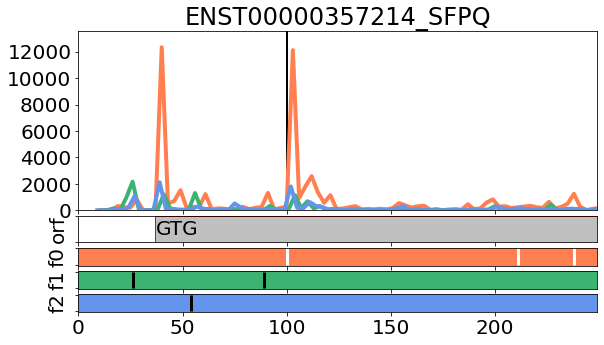

In [151]:
gene = 'SFPQ'

tr_id = R_Set[R_Set['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =2000, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='DHFR', font1=20, font2=24)

In [152]:
start_of_ext =  R_Set[R_Set['gene'] == gene].iloc[0].pos_of_codon
codon = R_Set[R_Set['gene'] == gene].iloc[0].codon
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
                                                                               start_of_ext, 
                                                                               end_of_CDS,
                                                                               codon
                                                                               ))

print (R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

tr_id: ENST00000357214; start of extension: 36; end of CDS: 2223; start codon: GTG
chr1:35193050-35193148 -


#### SFPQ mouse

In [159]:
transcript_seq = meta_mice14[meta_mice14['gene'] == 'Sfpq'].iloc[0].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == 'Sfpq'].iloc[0].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == 'Sfpq'].iloc[0].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == 'Sfpq'].iloc[0].gene)
print ( meta_mice14[meta_mice14['gene'] == 'Sfpq'].iloc[0].tr_id)
print (30, cds_stop)

Sfpq
ENSMUST00000030623.7
30 2193


In [157]:
#transcript_seq[cds_start:cds_stop]

transcript_seq[30:cds_stop]

'GTGGCAACCACGTTCCCTGAGCGACTTCTCCGCTTCTGCCTCGACCGCCCCTTGACTACAGCTATGTCTCGGGATCGGTTCCGGAGTCGCGGTGGCGGCGGTGGAGGCTTTCACCGGCGTGGAGGAGGTGGCGGCCGCGGCGGCCTTCACGACTTCCGCTCTCCGCCGCCGGGCATGGGCCTCAACCAGAACCGCGGCCCCATGGGCCCGGGCCCTGGCGGCCCGAAGCCGCCGCTCCCGCCTCCACCTCCTCACCAGCAGCAGCAGCAGCCGCCGCCGCAGCAGCCTCCGCCGCAGCAGCCGCCGCCGCACCAGCAGCCGCCGCCGCACCAGCCGCCCCATCAACAGCCCCCGCCTCCGCCGCAGGAATCCAAGCCCGTCGTCCCCCAAGGCCCCGGCTCGGCGCCGGGGGTGAGCAGTGCGCCTCCGCCGGCGGTCTCGGCTCCGCCCGCCAACCCCCCGACCACCGGCGCCCCTCCGGGCCCTGGTCCAACCCCGACTCCGCCGCCCGCCGTCCCCTCCACCGCCCCCGGACCGCCTCCCCCATCGACGCCGAGCAGCGGAGTCTCGACCACCCCTCCACAGACCGGCGGCCCTCCGCCACCGCCCGCCGGGGGCGCCGGGCCGGGGCCTAAGCCGGGGCCAGGCCCTGGCGGTCCAAAAGGCGGCAAGATGCCCGGTGGGCCTAAGCCTGGAGGTGGCCCGGGCATGGGCGCTCCTGGTGGCCACCCGAAGCCACCACACCGAGGTGGCGGCGAGCCCCGTGGGGGCCGGCAGCATCATGCGCCCTACCACCAGCAGCACCACCAGGGGCCCCCTCCCGGCGGACCGGGACCGCGCACGGAGGAGAAGATCTCCGACTCGGAGGGATTTAAAGCCAACTTGTCTCTCTTGCGGAGGCCTGGAGAAAAAACTTACACACAGCGCTGTCGGTTGTTTGTGGGGAATCTACCTGCTGATATCACAGAGGATGAATTCAAAAGACTGTTTGCTAAATAC

# VANGL2

128
0


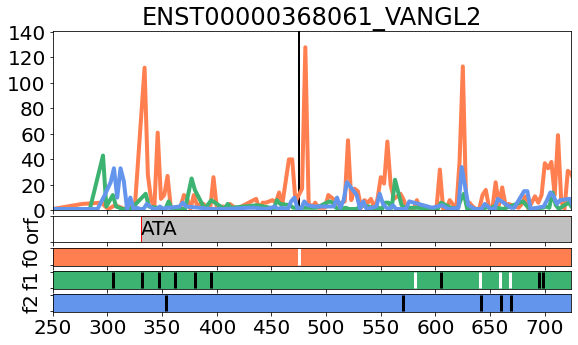

In [160]:
gene = 'VANGL2'

tr_id = P_Set[P_Set['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [250, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =20, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='VANGL2', font1=20, font2=24)

In [161]:
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
                                                                               pos_pred_start, 
                                                                               end_of_CDS,
                                                                               pred_start
                                                                               ))

tr_id: ENST00000368061; start of extension: 331; end of CDS: 2040; start codon: ATA


In [162]:
P_Set[P_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, P_Set[P_Set['tr_id'].str.contains(tr_id)].iloc[0].strand

('chr1:160400718-160400869+chr1:160415648-160415837', '+')

### vangl2 in mice 

In [169]:
gene_m = 'Vangl2'

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].tr_id)
print (346, cds_stop)

# expect ATA 

Vangl2
ENSMUST00000027837.12
346 2056


In [166]:
transcript_seq[346:2056]

'ATAGAGTCCCTCAGGGTGACGGTTGACTTCCTAAAGGTGCCTCTTGGCCTGAAGAAGCCTGTGCTGAAGGAGGTGGCTGTGGGACCCCCCAAGAGGTCCCAGCCCGCGGCCCTGGAGCGCTACAAGGCACGGCGTTCGGACGCCATGGACACCGAGTCCCAGTACTCGGGCTATTCCTACAAGTCGGGCCACTCCCGCAGCTCCCGGAAGCACAGGGACCGCCGGGACCGACACCGCTCTAAGAGCCGGGATGGGAGTCGTGGAGATAAATCAGTGACGATCCAGGCTCCGGGAGAACCCCTGCTGGACAATGAGTCCACGAGGGGGGATGAGCGGGATGACAACTGGGGAGAAACAACAACGGTGGTCACGGGCACTTCTGAGCACAGTATCTCCCATGATGACCTCACGCGCATCGCCAAGGACATGGAGGACAGTGTCCCGTTGGATTGTTCCCGCCACCTGGGCGTGGCGGCAGGGGCCATTCTGGCGCTGCTCTCGTTCCTCACCCCGCTGGCTTTCCTGCTGCTGCCTCCACTGCTGTGGCGGGAGGAGCTGGAGCCGTGTGGGACGGCCTGTGAGGGCCTCTTCATCTCCGTGGCCTTCAAGCTGCTCATCCTGCTGTTGGGCAGCTGGGCTCTGTTCTTCCGCCGGCCCAAGGCCTCACTGCCCCGAGTCTTCGTGTTACGAGCTCTGCTCATGGTGCTTGTCTTCCTGCTGGTTATTTCCTATTGGCTCTTCTACGGTGTGCGCATCTTGGACGCCCGGGAGCGGAGCTACCAGGGCGTGGTTCAGTTTGCCGTTTCTCTAGTGGATGCTTTACTCTTCGTGCACTATCTGGCCGTAGTTCTGCTGGAGCTCCGTCAGCTCCAGCCCCAGTTCACACTCAAGGTCGTGCGATCCACAGATGGGGCCAGCCGCTTCTACAATGTCGGCCATCTCAGCATCCAGCGAGTGGCAGTGTGGATCCTGGAGAAGTATTACCATGACTTCCCTGTC

In [168]:
transcript_seq[361:2056]

'GTGACGGTTGACTTCCTAAAGGTGCCTCTTGGCCTGAAGAAGCCTGTGCTGAAGGAGGTGGCTGTGGGACCCCCCAAGAGGTCCCAGCCCGCGGCCCTGGAGCGCTACAAGGCACGGCGTTCGGACGCCATGGACACCGAGTCCCAGTACTCGGGCTATTCCTACAAGTCGGGCCACTCCCGCAGCTCCCGGAAGCACAGGGACCGCCGGGACCGACACCGCTCTAAGAGCCGGGATGGGAGTCGTGGAGATAAATCAGTGACGATCCAGGCTCCGGGAGAACCCCTGCTGGACAATGAGTCCACGAGGGGGGATGAGCGGGATGACAACTGGGGAGAAACAACAACGGTGGTCACGGGCACTTCTGAGCACAGTATCTCCCATGATGACCTCACGCGCATCGCCAAGGACATGGAGGACAGTGTCCCGTTGGATTGTTCCCGCCACCTGGGCGTGGCGGCAGGGGCCATTCTGGCGCTGCTCTCGTTCCTCACCCCGCTGGCTTTCCTGCTGCTGCCTCCACTGCTGTGGCGGGAGGAGCTGGAGCCGTGTGGGACGGCCTGTGAGGGCCTCTTCATCTCCGTGGCCTTCAAGCTGCTCATCCTGCTGTTGGGCAGCTGGGCTCTGTTCTTCCGCCGGCCCAAGGCCTCACTGCCCCGAGTCTTCGTGTTACGAGCTCTGCTCATGGTGCTTGTCTTCCTGCTGGTTATTTCCTATTGGCTCTTCTACGGTGTGCGCATCTTGGACGCCCGGGAGCGGAGCTACCAGGGCGTGGTTCAGTTTGCCGTTTCTCTAGTGGATGCTTTACTCTTCGTGCACTATCTGGCCGTAGTTCTGCTGGAGCTCCGTCAGCTCCAGCCCCAGTTCACACTCAAGGTCGTGCGATCCACAGATGGGGCCAGCCGCTTCTACAATGTCGGCCATCTCAGCATCCAGCGAGTGGCAGTGTGGATCCTGGAGAAGTATTACCATGACTTCCCTGTCTACAACCCCGCCCTC

# CCDC8

146
0


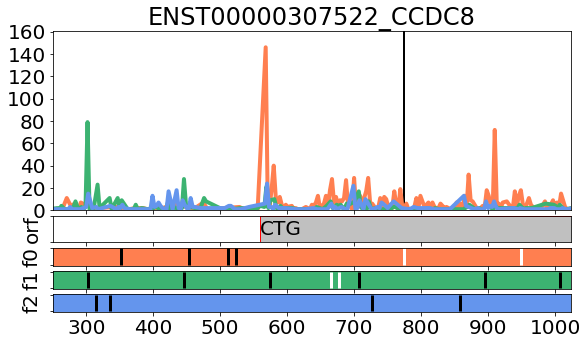

In [170]:
gene = 'CCDC8'

tr_id = P_Set[P_Set['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
pred_start = 'CTG'#meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0])
#pos_pred_start = pos_pred_start-6

pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [250, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =20, 
                             fraq = 100, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='VANGL2', font1=20, font2=24)

In [171]:
start_of_ext =  R_Set[R_Set['gene'] == gene].iloc[0].pos_of_codon
codon = 'CTG'#R_Set[R_Set['gene'] == gene].iloc[0].codon
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
                                                                               start_of_ext-6, 
                                                                               end_of_CDS,
                                                                               codon
                                                                               ))

print (R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
       R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

tr_id: ENST00000307522; start of extension: 552; end of CDS: 2391; start codon: CTG
chr19:46412811-46413059 -


In [172]:
P_Set[P_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, P_Set[P_Set['tr_id'].str.contains(tr_id)].iloc[0].strand

('chr19:46412811-46413059', '-')

In [173]:
558-6

552

In [174]:
int(pos_pred_start)

559

In [175]:
tr_seq[552:2391]

'CCAGATATCACCCTGGAGATCTTAAAGACTCTCGAGAAAAGCCACGTGGGGGGCTGGTTCCCCTGGGGCTTCCTGCCGTCCCCCGACTGCCTCATTCTTTGGAGCGTCCCCGATGTCTGCAAAGATGTGGATTTGGACGTCCTCGTGGAAGCCCTAAAGCCCGTGGGGACATTTAAGAAGATCGGCAAGGTGTTCCGCAAGGAGGAGGACTCCACGGTGGGGATGCTGCAGATCGGGGAGGACGTCGACTATTTGCTCATCCCCCGGGAGGTCAGGCTGGCTGGGGGCGTCTGGAGAGTCATCTCTAAGCCCGCCACCAAGGAAGCAGAATTTCGGGAGCGGCTGACCCAGTTCCTGGAAGAAGAGGGCCGCACCCTGGAGGACGTGGCCCGCATCATGGAGAAGAGCACCCCGCACCCGCCCCAGCCCCCCAAAAAGCCCAAGGAGCCCCGAGTGAGGAGGAGAGTGCAGCAGATGGTGACTCCTCCGCCCCGGCTGGTCGTGGGCACGTACGACAGCAGCAACGCCAGCGACAGCGAGTTCAGCGACTTCGAGACCTCCAGAGACAAGAGCCGCCAGGGCCCGCGGCGGGGCAAGAAGGTGCGCAAAATGCCCGTCAGCTACCTGGGCAGCAAGTTCCTGGGAAGCGACCTGGAGAGTGAGGATGATGAGGAACTGGTCGAGGCCTTCCTCCGGCGACAGGAGAAGCAGCCCAGCGCGCCGCCTGCCCGCCGCCGCGTCAACCTGCCAGTGCCCATGTTTGAGGACAACCTGGGGCCTCAGCTGTCCAAAGCGGACAGGTGGCGGGAGTATGTCAGCCAGGTGTCCTGGGGGAAGCTGAAGCGGAGGGTGAAGGGTTGGGCGCCGAGGGCGGGCCCCGGGGTGGGCGAGGCCCGGCTGGCCTCCACCGCAGTGGAGAGCGCAGGGGTATCATCGGCGCCAGAGGGCACCAGCCCGGGGGATCGCTTGGGAAACGCGGGAGATGTTTGTGTGCCCCAG

### mice CCDC8

In [178]:
gene_m = 'Ccdc8'

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].tr_id)
print (346, cds_stop)

# expect ATA 

Ccdc8
ENSMUST00000094805.4
346 3938


In [181]:
transcript_seq[1670:3938]

'CTGGAGATCTTAAAGACTCTCGAAAAAAGCCACGTAGGGGGATGGTTCCCCTGGGGCTTCCTTCCGTCTCCCGATTGCCTGATCCTCTGGAGTGTCCCCGACGTCTGCAAAGATGTCGATCTGGACGTGTTAGTGGAGGCCTTAAGGCCTGTGGGCACCTTTAAGAAAATCGGAAAGGTGTTCCGCAAAGAAGAGGACTCCACGGTGGGGATGCTGCAGATTGGGGAGGATGTTGACTATCTGCTCATCCCCCGGGAGGTCCGCCTGGCTGGGGGCGTGTGGAGAGTCATCTCCAAGCCTGCAACGAAGGAAGCTGAGTTTCGGGAGCGGCTAATCCAGTTTTTGCAGGAGGAGGGCCGCACCCTGGAAGATGTGGCCCGTATCATCGAAAAGAGCACTCCACACCCACCCCAACCCCGCAAAAGAACCAAGGAGCTGAGAGTGAGGAGAGTCCCGCAGATGGTCACTCCTCCACTTCGGCTGGTTGTAGGTACCTATGACAGCAGCAATGGCAGCGACAGTGAGTTGAGTGACTTCGATACCTCCAAAGTCAAAGGCAACAGGAGCTCCTCCGGGAGGACCAGGAAGGTGCGCAAAATGCCGGTCAGTTACTTGGGCAGCAAATTCCTGGGCAGCGATGTGGAGAGTGAGGATGATCAGGAGCTGGTGGAGGCCTTCCTCCGCCGTGGGGAGAAGCCCAGCGCGCCTCCTCCACGACGCCGAGTCAATCTTCCAGTGCCCATGTTTGAGAACAACCTGGGGCCCCAGCCATCCAAGGCCGACAGATGGAGGGAGTATGTTAGCCAGGTGTCCTGGGGGAAGCTGAAACAGAGGGTGAAGGGCTGGGCACCCAGATCAGGCTCCGAGGTGGGCCAGACCCAGCAGGCCTCCACAGCAGCTGAGAGGGCTGGAGAAATGAGACACAGCCAAGCCAGCTCGGACGATGATAGCTCCAGAAACACAGGAGACCGGAGTGACCAGATGCTGGGTACTAGACGC

# USP19

504
0


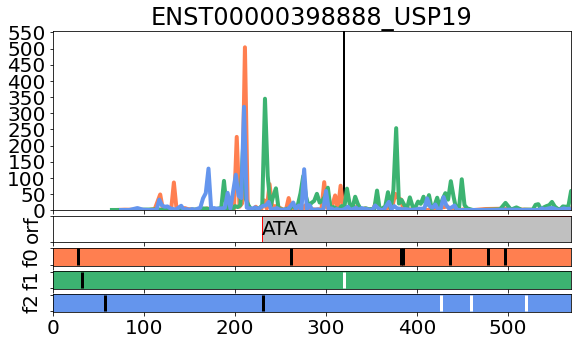

In [182]:
gene = 'USP19'

tr_id = R_Set[R_Set['gene'].str.contains(gene)].iloc[0].tr_id.split('.')[0]
    
pred_start = 'ATA'#meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0])+3
#pos_pred_start = pos_pred_start-6

pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                               file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =50, 
                             fraq = 100, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='USP19', font1=20, font2=24)

In [183]:
R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].strand

('chr3:49119146-49119281+chr3:49120756-49120904', '-')

In [184]:
tr_id

'ENST00000398888'

In [107]:
start_of_ext =  R_Set[R_Set['gene'] == gene].iloc[0].pos_of_codon
codon = 'CTG'#R_Set[R_Set['gene'] == gene].iloc[0].codon
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
                                                                               start_of_ext-6, 
                                                                               end_of_CDS,
                                                                               codon
                                                                               ))

print (R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
       R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

tr_id: ENST00000398888; start of extension: 220; end of CDS: 4276; start codon: CTG
chr3:49119146-49119281+chr3:49120756-49120904 -


## mouse USP19

In [185]:
gene_m = 'Usp19'

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].tr_id)
print (346, cds_stop)

# expect ATA 

Usp19
ENSMUST00000006854.12
346 4513


In [186]:
transcript_seq[340:4513]

'ATAGCTGGGCCGGGAAGAAAGCGCCGCAGCCCTGACCCAGACGCTGTTGCCGACTCTGGGCCACTCTGGCTGGCTACCAAGCGGCTCAAGATGTCTGCAGGGGCCAGTGCTACAGGGCCCAGGAGGGGGCCGCCAGGACTGGAAGAGGCCACTAGTAAGAAGAAACAGAAGGATCGAGCAAACCTGGAAAGTAAAGATGGAGATGCTAGGAGAGTGTCCCTTCCTCGAAAGGAACCAACCAAAGATGAATTGTTGCTCGATTGGAGGCAGAGTGCAGATGAGGTGATTGTTAAGCTGCGCGTGGGAACAGGTCCCGTACGTCTGGAGGATGTAGATGCTGCGTTCACAGACACGGACTGTGTGGTGAGGCTTCCAGATGGTCGGCAGTGGGGTGGTGTCTTCTTTGCTGAAATACAAAGTTCTTGCACCAAAGTGCAGGCTCGCAAGGGTGGTCTTCTACAGCTAGTACTACCCAAGAAGGTGCCTCTGCTCACGTGGCCCTCTCTCCTGAAACCTCTGGGAACCCAAGAGCTGGTGCCAGGTTTGCAGTGCCAGGAGAACGGGCAAGAGCTGTCTCCCATTGCCCTGGAGCCAGGCTCTGAGCCCCGCAGAGCTAAACAGGAAGCCCGAAACCAGAAGCGGGCCCAGGGCCGTGGTGAGGTAGGCTCGGGGGCTGGCCCTGGGACACAGGCAGGGCCCAGCGCCAAGAGGGCTGTTCACCTCCGCAGAGGGCCAGAAGGGGAAGGGTCCATGGATGGCCCCGGCCCCCAGGGTGATGCCCCGTCTTTCCTGTCTGACTCAGCTACCCAGGTTGAGGCTGAGGAGAAGCTCTGTGCTCCACCAATGAACACTCAAACAAGTCTCTTGAGCTCAGAGAAGAGTTTAGCCCTTCTGACAGTAGAGAAGACAGTGTCCCCCAGGAATGACCCAGTCGCCCCGGTTATGGTCCAGGACAGAGACCCTGAGCCTGAGCAAGAAGACCAAGTCAAAGAGGAGATG

# TRPC1 

N-t extension to CTG, looks good with stalled ribo-seq so annotated

In [187]:
meta[meta['tr_id'].str.contains(tr_id)]

,tr_id,N_term_start,N_term_end,len,N_term_start1,N_term_end1,len_codons,gene,50len_flag,global_coo_50_and_less,...,gene_ext,Start_ext,Stop_ext,global_rank_ext,Start_codon_ext,Proteomics_count_ext,Coverage_value_ext,CDS_ratio,Riboseq_Summary,Nstart_Nend
13126,ENST00000398888.6,34,319,285,34,319,95.0,USP19,169,chr3:49119146-49119281+chr3:49120756-49120769,...,USP19,227.0,320.0,236.0,AAG,0.0,61.538462,1.109651,AAG; 227-320; Rank: 236; cov: 61.54,34-319


56
0


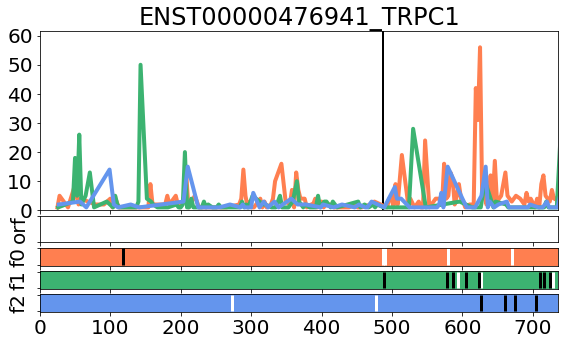

In [188]:
gene = 'TRPC1'

tr_id = P_Set[P_Set['gene'].str.contains(gene)].iloc[0].tr_id.split('.')[0]
    
#pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
#pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0])
#pos_pred_start = pos_pred_start-6

pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                               file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=False, 
                            l=10, 
                            p =10, 
                             fraq = 100, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='USP19', font1=20, font2=24)

In [189]:
print (P_Set[P_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
       P_Set[P_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

chr3:142724194-142724559 +


In [190]:
tr_id

'ENST00000476941'

In [191]:
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos

In [192]:
end_of_CDS

2868

## TRPC1 mouse 

In [43]:
gene_m = 'Trpc1'

i = 1

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[i].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[i].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[i].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[i].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[i].tr_id)
print (346, cds_stop)

# expect ATA 

Trpc1
ENSMUST00000053785.9
346 2799


In [44]:
#transcript_seq[334:]
meta_mice14[meta_mice14['gene'] == gene_m]

,tr_id,gene,gene_tr,transcript_seq,5UTR_start_seq,CDS_start,cds_seq,cds_start_codon,cds_stop_codon,cds_start_pos,cds_stop_pos,utr5_start,utr5_end,record_id,tr_id_len
35164,ENSMUST00000189137.6,Trpc1,Trpc1-204,CGTCGCCTCCGCGGGGCTGAGGATGACGTGAGGAGAAAGCCGCGAA...,CGTCGCCTCCGCGGGGCTGAGGATGACGTGAGGAGAAAGCCGCGAA...,CCC,ATGGGGGCCCCGCCTCCGTCTCCTGGCCTGCCCCCGTCGTGGGCCG...,ATG,TAA,471,2901,0,471,ENSMUST00000189137.6|ENSMUSG00000032839.13|OTT...,4559
35165,ENSMUST00000053785.9,Trpc1,Trpc1-201,CGTCGCCTCCGCGGGGCTGAGGATGACGTGAGGAGAAAGCCGCGAA...,CGTCGCCTCCGCGGGGCTGAGGATGACGTGAGGAGAAAGCCGCGAA...,CCC,ATGGGGGCCCCGCCTCCGTCTCCTGGCCTGCCCCCGTCGTGGGCCG...,ATG,TAA,471,2799,0,471,ENSMUST00000053785.9|ENSMUSG00000032839.13|OTT...,2912
35166,ENSMUST00000190604.6,Trpc1,Trpc1-207,CGTCGCCTCCGCGGGGCTGAGGATGACGTGAGGAGAAAGCCGCGAA...,CGTCGCCTCCGCGGGGCTGAGGATGACGTGAGGAGAAAGCCGCGAA...,CCC,ATGGGGGCCCCGCCTCCGTCTCCTGGCCTGCCCCCGTCGTGGGCCG...,ATG,TAA,471,771,0,471,ENSMUST00000190604.6|ENSMUSG00000032839.13|OTT...,2757
35167,ENSMUST00000190497.1,Trpc1,Trpc1-206,CGTCGCCTCCGCGGGGCTGAGGATGACGTGAGGAGAAAGCCGCGAA...,CGTCGCCTCCGCGGGGCTGAGGATGACGTGAGGAGAAAGCCGCGAA...,CCC,ATGGGGGCCCCGCCTCCGTCTCCTGGCCTGCCCCCGTCGTGGGCCG...,ATG,TGA,471,726,0,471,ENSMUST00000190497.1|ENSMUSG00000032839.13|OTT...,2859
35168,ENSMUST00000186235.1,Trpc1,Trpc1-202,AAACTTATGGAACGAATTCAGAATCCAGAATATTCAACAACGATGG...,None,AAA,AAACTTATGGAACGAATTCAGAATCCAGAATATTCAACAACGATGG...,AAA,TCA,0,765,0,0,ENSMUST00000186235.1|ENSMUSG00000032839.13|OTT...,765


# SLC6A1

1
0


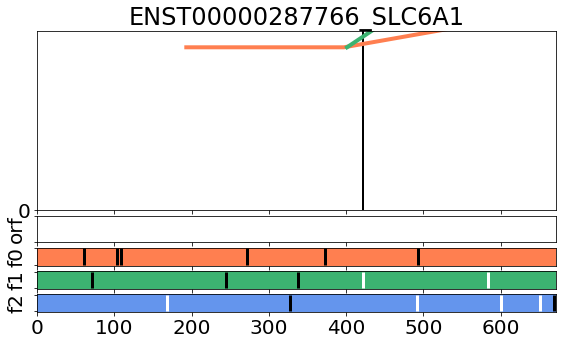

In [199]:
gene = 'SLC6A1'

tr_id = P_Set[P_Set['gene'].str.contains(gene)].iloc[0].tr_id.split('.')[0]
    
pred_start = 'ATA'#meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0])+3
#pos_pred_start = pos_pred_start-6

pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                               file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=False, 
                            l=10, 
                            p =50, 
                             fraq = 100, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='USP19', font1=20, font2=24)

In [200]:
print (P_Set[P_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
       P_Set[P_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

chr3:11017131-11017211 +


In [201]:
tr_id

'ENST00000287766'

In [195]:
#start_of_ext =  P_Set[P_Set['gene'] == gene].iloc[0].pos_of_codon
#codon = 'CTG'#R_Set[R_Set['gene'] == gene].iloc[0].codon
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
#tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

#print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
#                                                                               start_of_ext-6, 
#                                                                               end_of_CDS,
#                                                                               codon
#                                                                               ))

#print (R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
#       R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

end_of_CDS

2221

### SLC6A1 mouse

In [202]:
gene_m = 'Slc6a1'

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].tr_id)
print (346, cds_stop)

# expect ATA 

Slc6a1
ENSMUST00000032454.7
346 2179


In [204]:
transcript_seq[349:2179]

'ATCCCCGCTGCCAAGTTTGTGCTCCGAGACATGGCGACTGACAACAGCAAGGTGGCTGATGGGCAGATCTCTACTGAGGTCAGCGAGGCCCCTGTGGCCAGCGACAAGCCCAAAACCCTGGTAGTCAAGGTGCAGAAGAAGGCCGGGGACCTCCCTGACCGGGACACATGGAAGGGACGCTTCGACTTCCTCATGTCCTGCGTGGGCTATGCCATCGGCCTGGGCAATGTGTGGAGGTTCCCTTACCTCTGTGGGAAAAACGGTGGCGGGGCCTTCCTAATCCCATATTTCCTGACGCTCATCTTTGCGGGTGTTCCTCTCTTCCTTTTGGAGTGCTCCCTAGGCCAGTACACCTCCATTGGGGGCCTGGGCGTATGGAAGCTGGCGCCCATGTTCAAGGGTGTGGGCCTCGCGGCAGCTGTGCTGTCCTTCTGGCTGAACATCTACTACATCGTCATCATCTCCTGGGCCATCTACTACCTGTACAACTCCTTCACCACGACCCTGCCATGGAAACAGTGTGACAACCCGTGGAACACTGACCGCTGCTTCTCCAACTACAGCCTGGTCAATACCACCAACATGACCAGCGCCGTGGTGGAGTTCTGGGAGCGCAACATGCACCAGATGACAGATGGACTGGACAAGCCAGGACAGATCCGCTGGCCTCTGGCCATCACACTGGCCATTGCCTGGGTGCTCGTGTATTTCTGCATCTGGAAGGGTGTTGGTTGGACTGGAAAGGTGGTCTACTTCTCAGCCACGTACCCCTACATCATGCTTATCATCCTGTTCTTCCGTGGAGTGACGCTTCCCGGGGCCAAGGAGGGGATCCTCTTCTACATCACACCCAACTTCCGAAAGCTGTCTGATTCTGAGGTGTGGCTTGACGCCGCCACCCAGATCTTCTTCTCCTACGGGCTGGGCCTGGGGTCCCTGATTGCTCTGGGAAGCTACAACTCTTTCCACAACAATGTGTACAGGGACTCCATCATCGTT

# 8 genes that are ovlp between RiboSET and PhyloSET 

In [120]:
set(R_Set.gene.tolist()).intersection(P_Set.gene.tolist())

{'CCDC8', 'CYTH2', 'FXR2', 'H1FX', 'HNRNPA0', 'MARCKS', 'RPTOR', 'SFPQ'}

# RPTOR

194
0


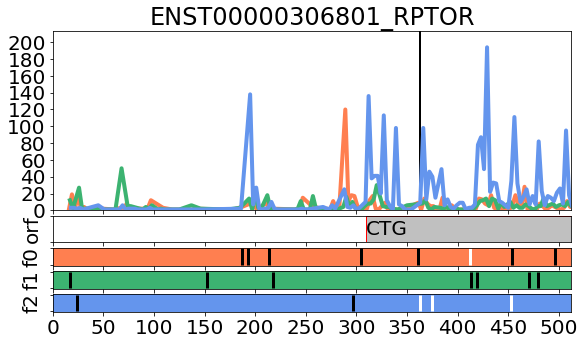

In [205]:
gene = 'RPTOR'

tr_id = R_Set[R_Set['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
pred_start = 'CTG' #meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0])+3 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =20, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='DHFR', font1=20, font2=24)

In [206]:
start_of_ext =  int(R_Set[R_Set['gene'] == gene].iloc[0].pos_of_codon)+3
codon = 'CTG'#R_Set[R_Set['gene'] == gene].iloc[0].codon
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
                                                                               start_of_ext, 
                                                                               end_of_CDS,
                                                                               codon
                                                                               ))

print (R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
       R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

tr_id: ENST00000306801; start of extension: 308; end of CDS: 4370; start codon: CTG
chr17:80545567-80545629 +


In [207]:
tr_seq[308:4370]

'CTGGAGGTTCTCGAGCGCTTGCTGCCAAGGACTCCCCCACCCCCTCCCCCACTGATGGAGTCCGAAATGCTGCAATCGCCTCTTCTGGGCCTGGGGGAGGAAGATGAGGCTGATCTTACAGACTGGAACCTACCTTTGGCTTTTATGAAAAAGAGGCACTGTGAGAAAATTGAAGGCTCCAAATCCTTAGCTCAGAGCTGGAGGATGAAGGATCGGATGAAGACAGTCAGTGTTGCCTTAGTTTTGTGCCTGAATGTTGGTGTGGACCCTCCCGATGTGGTGAAGACCACGCCCTGTGCACGCTTGGAATGCTGGATCGATCCTCTGTCGATGGGTCCTCAGAAAGCTCTGGAAACCATCGGTGCAAATTTACAGAAGCAGTACGAGAACTGGCAGCCAAGGGCCCGGTACAAGCAGAGCCTTGACCCAACTGTGGATGAAGTCAAGAAGCTCTGCACGTCCTTACGTCGCAACGCCAAGGAGGAGCGAGTCCTCTTTCACTACAATGGCCACGGGGTGCCCCGGCCCACAGTCAACGGGGAGGTCTGGGTCTTCAACAAGAACTACACGCAGTACATCCCTCTGTCCATATATGACCTGCAGACGTGGATGGGCAGCCCGTCGATCTTCGTCTACGACTGCTCCAATGCTGGCTTGATCGTCAAGTCCTTCAAGCAGTTCGCACTACAGCGGGAGCAGGAGCTGGAGGTAGCTGCAATCAACCCAAATCACCCTCTTGCTCAGATGCCTTTGCCTCCGTCGATGAAAAACTGCATCCAGCTGGCAGCCTGCGAGGCCACCGAGCTGCTGCCCATGATCCCCGACCTCCCGGCTGACCTATTCACCTCCTGCCTCACCACCCCCATCAAGATCGCCCTGCGCTGGTTTTGCATGCAGAAATGTGTCAGTCTGGTGCCTGGCGTCACACTGGATTTGATAGAAAAGATCCCTGGCCGCCTGAACGACAGGAGGACGCCCCTGGGTGAACTGAACTGGATC

### RPTOR mouse 

In [246]:
gene_m = 'Rptor'

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].tr_id)
print (346, cds_stop)

# expect ATA 

Rptor
ENSMUST00000026671.12
346 4669


In [247]:
transcript_seq[607:]

'CTGGAGGTTCTCGAGCGCCTGCTGCCAAGGACTCCCCCTCCCCCTCCTCCCCTGATGGAGTCGGAGATGCTGCAGTCGCCTCTTATGGGACTCGGGGAGGAAGATGAGGCGGACCTTACAGATTGGAACTTGCCTTTGGCTTTTATGAAGAAAAGACATTGTGAGAAAATCGAAGGCTCCAAATCTTTAGCGCAGAGCTGGAGAATGAAGGATCGGATGAAGACGGTGAGTGTGGCCTTGGTCCTGTGCCTGAATGTGGGTGTGGATCCTCCGGATGTGGTGAAGACCACACCCTGTGCTCGGCTGGAATGCTGGATCGATCCTCTGTCTATGGGCCCTCAGAAAGCTCTGGAAACCATCGGTGCAAACCTACAGAAGCAGTATGAGAACTGGCAGCCAAGGGCTCGGTACAAGCAGAGCCTCGACCCTACTGTGGATGAAGTCAAGAAACTTTGCACATCTCTGCGCCGGAACGCCAAGGAGGAACGGGTCCTTTTCCACTACAATGGCCACGGGGTGCCCAGGCCTACAGTGAATGGAGAGGTCTGGGTCTTCAACAAGAACTACACTCAGTACATCCCTCTGTCCATATACGACCTGCAGACGTGGATGGGCAGCCCATCCATCTTTGTCTACGACTGTTCCAATGCTGGCCTCATCGTCAAGTCCTTCAAACAGTTTGCACTGCAGAGGGAGCAGGAACTAGAGGTAGCTGCGATTAACCCAAACCATCCACTTGCCCAGATGCCCTTGCCTCCCTCAATGAAAAACTGCATCCAGTTGGCAGCGTGTGAGGCACACGAGCTGCTGCCCATGATCCCTGACCTCCCAGCCGACCTGTTCACATCCTGCCTCACCACTCCCATCAAGATTGCTCTGCGCTGGTTTTGCATGCAGAAGTGCGTGAGTCTGGTGCCTGGAGTCACACTGGATTTGATAGAAAAGATCCCTGGCCGGCTGAATGACCGGAGGACCCCTCTGGGAGAGCTGAACTGGATC

# MARCKS

5218
0


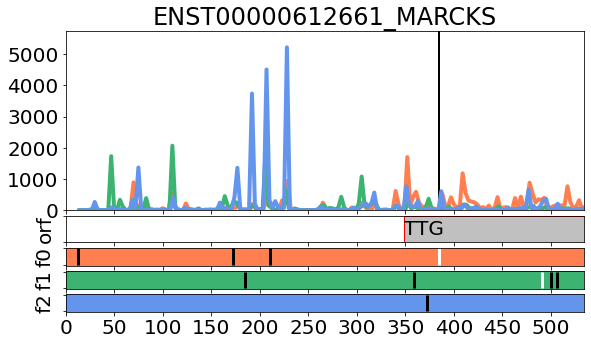

In [209]:
gene = 'MARCKS'

tr_id = R_Set[R_Set['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =1000, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='DHFR', font1=20, font2=24)

In [210]:
start_of_ext =  int(R_Set[R_Set['gene'] == gene].iloc[0].pos_of_codon)
codon = R_Set[R_Set['gene'] == gene].iloc[0].codon
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
                                                                               start_of_ext, 
                                                                               end_of_CDS,
                                                                               codon
                                                                               ))

print (R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
       R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

tr_id: ENST00000612661; start of extension: 348; end of CDS: 1383; start codon: TTG
chr6:113857575-113857745 +


### MARCKS mouse 

In [248]:
gene_m = 'Marcks'

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].tr_id)
print (346, cds_stop)

# expect ATA 

Marcks
ENSMUST00000092584.5
346 1315


In [249]:
transcript_seq[337:1315]

'TTGTTTCCTCTCTTGGATCTGTTGAGTTTCTTTGTTGAAGAAGCCAGCATGGGTGCCCAGTTCTCCAAGACCGCAGCGAAGGGAGAAGCCACCGCCGAGAGGCCCGGGGAGGCGGCTGTGGCCTCGTCGCCTTCCAAAGCAAATGGGCAGGAGAATGGCCACGTAAAAGTGAACGGGGACGCGTCTCCCGCCGCCGCCGAGCCGGGCGCCAAGGAGGAGCTGCAAGCCAACGGCAGCGCCCCGGCCGCCGACAAGGAGGAGCCCGCGAGCGGCAGTGCCGCGACCCCCGCCGCGGCCGAAAAGGATGAGGCTGCCGCGGCCACCGAGCCGGGCGCCGGCGCGGCCGACAAGGAGGCTGCGGAGGCCGAGCCCGCCGAGCCCAGCTCCCCGGCCGCCGAGGCCGAGGGCGCGTCCGCCTCCTCCACGTCGTCGCCCAAGGCGGAGGACGGGGCCGCGCCGTCGCCCAGCAGCGAGACCCCGAAAAAAAAAAAGAAGCGCTTTTCCTTCAAGAAGTCCTTCAAGCTGAGCGGCTTCTCCTTCAAGAAGAGCAAGAAGGAGTCGGGCGAGGGCGCTGAAGCAGAGGGAGCGACCGCGGAAGGCGCCAAGGACGAGGCTGCAGCCGCAGCGGGCGGCGAGGGGGCCGCGGCCCCCGGGGAGCAGGCAGGCGGGGCGGGCGCCGAGGGCGCGGCGGGCGGAGAGCCCCGGGAGGCCGAGGCGGCGGAGCCCGAGCAGCCGGAGCAGCCGGAGCAGCCCGCGGCGGAGGAGCCGCAGGCGGAGGAGCAGTCGGAGGCGGCGGGGGAGAAGGCGGAGGAGCCCGCGCCCGGCGCCACCGCGGGCGATGCGTCCTCCGCCGCAGGGCCTGAGCAGGAGGCGCCCGCTGCCACCGACGAGGCCGCGGCGTCCGCAGCCCCCGCCGCGTCGCCGGAGCCGCAGCCCGAGTGCAGTCCGGAGGCGCCCCCCGCGCCAACGGCCGAGTAA'

# HNRNPA0

9412
0


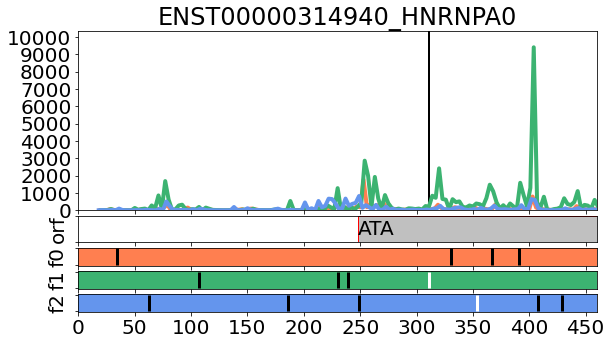

In [212]:
gene = 'HNRNPA0'

tr_id = R_Set[R_Set['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =1000, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='DHFR', font1=20, font2=24)

In [213]:
start_of_ext =  int(R_Set[R_Set['gene'] == gene].iloc[0].pos_of_codon)
codon = R_Set[R_Set['gene'] == gene].iloc[0].codon
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
                                                                               start_of_ext, 
                                                                               end_of_CDS,
                                                                               codon
                                                                               ))

print (R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
       R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

tr_id: ENST00000314940; start of extension: 247; end of CDS: 1228; start codon: ATA
chr5:137754067-137754135 -


In [163]:
tr_seq[247:260]

'ATAACGGCGGCGA'

### HNRNPA0 mouse 

In [251]:
gene_m = 'Hnrnpa0'

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].tr_id)
print (346, cds_stop)

# expect ATA 

Hnrnpa0
ENSMUST00000007980.6
346 1161


In [252]:
transcript_seq[192:1161]

'ACGGCGACGCGGCGGAGCGCGCAGGGCGGGGGCAGGGCCCGGGCGGCCGACATGGAGAACTCGCAGCTCTGTAAGCTGTTCATCGGCGGCCTCAATGTGCAGACGAGTGAGTCGGGGCTGCGCGGCCACTTCGAGGCCTTCGGGACGCTGACGGACTGCGTGGTGGTGGTGAACCCCCAGACGAAGCGCTCCCGCTGCTTCGGCTTCGTGACCTACTCGAACGTGGAGGAGGCGGATGCCGCCATGGCCGCGTCGCCGCACGCGGTGGACGGCAACACGGTGGAGCTGAAGCGCGCCGTGTCGCGGGAGGATTCGGCGCGGCCCGGGGCGCACGCCAAGGTGAAGAAGCTGTTCGTGGGCGGCCTCAAGGGCGACGTGGCGGAGGGCGACCTGATCGAGCACTTCTCGCAGTTCGGCGCGGTGGAGAAGGCGGAGATCATTGCCGACAAGCAGTCGGGCAAGAAGCGCGGCTTCGGCTTCGTCTACTTCCAGAGCCACGACGCGGCCGACAAGGCCGCGGTGGTCAAGTTCCACCCGATCCAGGGCCACCGCGTGGAGGTGAAGAAGGCGGTGCCCAAGGAGGATATCCACGCGGGCGGCGGGGGTGCGCGGGCGGCCCGGGGCGGGCGCGGCGGAGGCCGGGGCCGCGGCGGCGGAGGCGGCGGCGGCGGCCGAGACCAGAACGGGCTGGCCAAGGGCGGCGGTGGCGGCGGCGGCGGCTACAACAGCTACGGCGGCTACGGGGGCTACGGCGCCTACGGGGGCGGTGGCGGCGGCGGCGGCTCATACGGCGGCAGCGACTACGGCAACGGCTTCGGCGGCTTCGGCAGCTACAGCCAGCACCAGTCCTCGTACGGGCCGATGAAGAGCGGCGGAGGCGGCGGCGGCGGCGGCAGCTGGGGCGGCCGCAGCAACAGTGGACCGTACAGAGGCGGCTACGGCGGCGGCTACGGCGGAGGCTCGTTCTAG'

# H1FX

7511
0


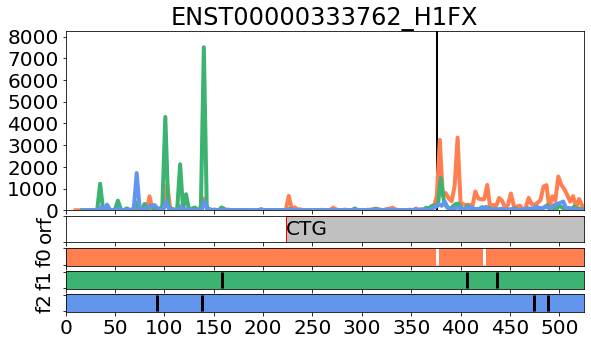

In [215]:
gene = 'H1FX'

tr_id = R_Set[R_Set['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =1000, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='DHFR', font1=20, font2=24)

In [216]:
start_of_ext =  int(R_Set[R_Set['gene'] == gene].iloc[0].pos_of_codon)
codon = R_Set[R_Set['gene'] == gene].iloc[0].codon
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
                                                                               start_of_ext, 
                                                                               end_of_CDS,
                                                                               codon
                                                                               ))

print (R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
       R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

tr_id: ENST00000333762; start of extension: 222; end of CDS: 1017; start codon: CTG
chr3:129315903-129316277 -


In [168]:
tr_seq[222:1017]

'CTGCCGCCCGGCCCCAGGCCCGGCCGCGGCCGCTCCCGCCTGGAGCCGCCGCGCGCCCCCAGCCCCCCTGCACCCCCTCGGCCCCTCGCCTTCCTCTTCCCGGCGCGGCCCCCCGGCTTCCGCGCGCCGCCCGCCACCAATCCTCTTGCTACCATGTCCGTGGAGCTCGAGGAGGCCCTGCCAGTGACGACCGCCGAGGGAATGGCCAAGAAGGTGACCAAGGCTGGCGGCTCGGCGGCGTTGTCCCCATCTAAGAAGAGGAAGAATAGCAAGAAGAAGAACCAGCCGGGCAAGTACAGCCAGCTGGTGGTGGAGACCATCCGTAGGCTGGGCGAGCGCAACGGCTCGTCGCTGGCCAAGATCTACACCGAGGCCAAGAAGGTTCCGTGGTTCGACCAGCAGAATGGGCGCACCTACCTCAAGTACTCGATCAAGGCGCTGGTGCAGAACGACACGCTTCTGCAGGTGAAGGGCACCGGCGCCAACGGTTCCTTCAAGCTCAACCGCAAGAAGCTGGAGGGCGGCGGGGAGCGGCGCGGAGCCCCGGCGGCCGCCACCGCCCCGGCCCCCACCGCGCACAAAGCGAAGAAGGCAGCCCCGGGCGCGGCCGGCTCCCGGCGCGCGGACAAGAAGCCCGCCAGGGGCCAGAAGCCGGAGCAGCGCTCGCACAAGAAGGGCGCTGGCGCCAAGAAGGACAAAGGCGGCAAGGCCAAGAAGACGGCGGCCGCCGGGGGCAAGAAGGTGAAGAAGGCGGCCAAGCCCAGCGTCCCCAAAGTGCCCAAGGGCCGCAAGTGA'

In [169]:
gene

'H1FX'

### H1FX mouse 

In [253]:
gene_m = 'H1fx'

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].tr_id)
print (346, cds_stop)

# expect ATA 

H1fx
ENSMUST00000056403.6
346 848


In [254]:
transcript_seq[128:848]

'CTGCCGCCTGGTCCCAGGCCCGGCCGCGGCCGCTCCCGCCTGGAGCCGCCGCGCGCCCCCAGTCCCCCGGCGCCGCCGCGGCCCCTCGCCTTCCTCTTCCCGGCGCGGCCCCCCGGCTACCGCGCGCCGCCTGCCGCCAACCCGCTGGCCACCATGTCGGTGGAGCTTGAGGAGGCCCTGCCGCCAACGAGCGCCGACGGGACGGCCCGCAAGACGGCCAAGGCCGGCGGCTCTGCGGCGCCCACGCAGCCCAAGAGAAGGAAGAACCGCAAGAAGAACCAGCCAGGCAAGTACAGCCAGCTGGTGGTGGAGACCATCCGCAAGCTGGGGGAGCGCGGCGGCTCGTCTCTGGCGCGCATCTACGCTGAGGCCAGGAAGGTGGCATGGTTCGACCAGCAGAACGGGCGCACCTACCTCAAGTACTCTATCCGGGCGCTGGTGCAGAACGATACGCTACTGCAGGTGAAGGGCACCGGCGCCAACGGATCCTTCAAGCTGAACCGCAAGAAGCTGGAGGGCGGCGCGGAGCGGCGCGGAGCTTCGGCGGCCAGCAGCCCCGCGCCCAAGGCGCGCACGGCGGCGGCGGACAGAACGCCCGCCAGGCCGCAGCCGGAGCGGCGCGCGCACAAGAGCAAGAAGGCGGCGGCTGCTGCCAGCGCGAAGAAAGTGAAGAAGGCGGCCAAACCCAGCGTGCCCAAGGTGCCCAAGGGCCGCAAGTGA'

In [255]:
transcript_seq[43:848]

'CTGCCGCGCTCCCCGCAGGCTCCTCTCCGCATCCCACCCCCCCAGCCCCGCCGCGGCCGGCCCGGCCCCCGCCCGCACCTCAGCCCTGCCGCCTGGTCCCAGGCCCGGCCGCGGCCGCTCCCGCCTGGAGCCGCCGCGCGCCCCCAGTCCCCCGGCGCCGCCGCGGCCCCTCGCCTTCCTCTTCCCGGCGCGGCCCCCCGGCTACCGCGCGCCGCCTGCCGCCAACCCGCTGGCCACCATGTCGGTGGAGCTTGAGGAGGCCCTGCCGCCAACGAGCGCCGACGGGACGGCCCGCAAGACGGCCAAGGCCGGCGGCTCTGCGGCGCCCACGCAGCCCAAGAGAAGGAAGAACCGCAAGAAGAACCAGCCAGGCAAGTACAGCCAGCTGGTGGTGGAGACCATCCGCAAGCTGGGGGAGCGCGGCGGCTCGTCTCTGGCGCGCATCTACGCTGAGGCCAGGAAGGTGGCATGGTTCGACCAGCAGAACGGGCGCACCTACCTCAAGTACTCTATCCGGGCGCTGGTGCAGAACGATACGCTACTGCAGGTGAAGGGCACCGGCGCCAACGGATCCTTCAAGCTGAACCGCAAGAAGCTGGAGGGCGGCGCGGAGCGGCGCGGAGCTTCGGCGGCCAGCAGCCCCGCGCCCAAGGCGCGCACGGCGGCGGCGGACAGAACGCCCGCCAGGCCGCAGCCGGAGCGGCGCGCGCACAAGAGCAAGAAGGCGGCGGCTGCTGCCAGCGCGAAGAAAGTGAAGAAGGCGGCCAAACCCAGCGTGCCCAAGGTGCCCAAGGGCCGCAAGTGA'

# FXR2

713
0


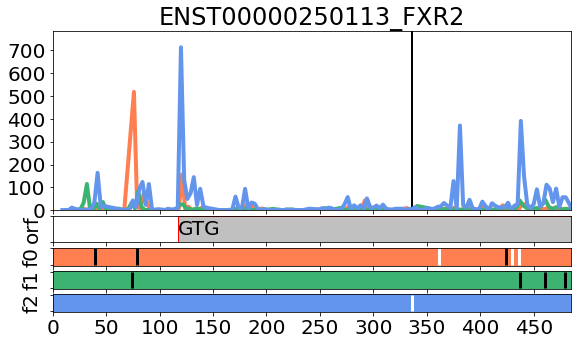

In [173]:
gene = 'FXR2'

tr_id = R_Set[R_Set['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='DHFR', font1=20, font2=24)

In [174]:
start_of_ext =  int(R_Set[R_Set['gene'] == gene].iloc[0].pos_of_codon)
codon = R_Set[R_Set['gene'] == gene].iloc[0].codon
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
                                                                               start_of_ext, 
                                                                               end_of_CDS,
                                                                               codon
                                                                               ))

print (R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
       R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

tr_id: ENST00000250113; start of extension: 116; end of CDS: 2357; start codon: GTG
chr17:7614533-7614865 -


In [175]:
gene

'FXR2'

In [176]:
tr_seq[116:]

'GTGGCGGAGACCAAGGCGGCGGCGGCGGACGGGGAGCGGCCCGGCCCCGGCCCCCTGCTCGTTGGCTGTGGCAGGGCCGCCGTGGGGCCGGCCCGGCTCCCGCCCCCCGCGGCTCCCCCTCCGGCTCCTCCTCCGGGGAGACGCCGGGGGCCTGGCCCGGCCCGCACTCAGACTGCTGCTGCAGCCGCCGCCGGGGGAGTCGGAGGCGGTGGCGGCGCCATGGGCGGCCTGGCCTCTGGGGGGGATGTGGAGCCGGGACTGCCCGTCGAGGTGCGCGGCTCCAACGGGGCCTTCTACAAGGGCTTTGTGAAGGATGTCCATGAAGACTCTGTCACCATCTTCTTTGAAAACAACTGGCAGAGTGAGAGACAAATTCCTTTTGGGGATGTCCGGCTACCACCTCCAGCTGACTATAATAAGGAGATCACAGAAGGGGATGAAGTGGAGGTTTATTCTCGAGCCAATGAACAGGAACCTTGTGGCTGGTGGCTGGCCCGGGTGCGGATGATGAAGGGAGATTTCTATGTCATTGAATATGCTGCCTGTGATGCCACCTACAATGAAATTGTTACCCTGGAGCGACTTCGGCCAGTTAATCCCAATCCCCTTGCAACCAAAGGCAGCTTCTTCAAGGTTACCATGGCTGTGCCCGAGGATCTGAGAGAAGCCTGCTCCAATGAAAACGTCCATAAAGAGTTCAAGAAAGCCCTGGGAGCCAACTGCATCTTTCTCAACATCACAAACAGTGAGCTCTTCATTCTGTCAACCACAGAAGCCCCTGTGAAGCGAGCATCTCTGCTGGGTGATATGCATTTCCGAAGCCTGCGCACCAAACTGCTACTTATGTCCCGCAATGAAGAAGCTACCAAGCACCTAGAGACAAGCAAGCAGTTGGCAGCAGCCTTCCAAGAGGAGTTCACAGTGCGAGAGGACCTGATGGGACTGGCAATTGGGACTCACGGTGCCAACATCCAGCAGGCCCGAAAAGTACCTGGGGTG

### Fxr2 mouse 

In [256]:
gene_m = 'Fxr2'

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].tr_id)
print (346, cds_stop)

# expect ATA 

Fxr2
ENSMUST00000018909.3
346 2353


In [257]:
transcript_seq[103:]

'GTGGCGGAGACCAAGGCAGCGGCGGCGGCGGCGGACGGGGAGCGGCCCGGCCCCGGCCCCCTGCTCGTCGGCTGTAGCAGGGCCGCCGTGGGGCCGGCCCGGCTCCCGCCCCCCGCGGCTCCCCCTCCGGCTCCTCCTCCAGGGAGACGCCGGGGACCCGGCCCGGCCCGCACTCAGGGCTCTGTTTCAGCTGCTGCCGGGCCAGTCGGAGGTGGTGGCGGCGCCATGGGCGGCCTGGCCTCTGGGGGGGATGTGGAGCCGGGACTGCCCGTCGAGGTGCGGGGCTCCAACGGGGCCTTCTACAAGGGCTTTGTAAAGGATGTCCATGAAGACTCTGTCACTATCTTCTTTGAGAACAACTGGCAGAGTGAGAGACAGATTCCCTTTGGGGATGTCCGACTACCGCCTCCAGCTGACTACAATAAGGAAATCACAGAAGGAGATGAAGTAGAGGTCTATTCGAGAGCCAATGAACAGGAACCTTGTGGCTGGTGGCTGGCCCGGGTGCGGATGATGAAGGGAGATTTCTATGTCATTGAGTACGCTGCCTGTGATGCTACCTACAATGAGATTGTCACTCTGGAACGACTTCGGCCAGTCAATCCCAGTCCCCTTGCAACCAAAGGCAGCTTCTTCAAGGTTACCATGGCTGTGCCTGAGGACCTCAGGGAGGCCTGCTCCAATGAAAATGTCCATAAGGAGTTCAAGAAAGCACTGGGAGCCAACTGCATCTTTCTCAACATCACAAACAGTGAGCTCTTTATTCTGTCAACCACAGAAGCCCCTGTGAAGAGGGCATCTTTGTTGGGTGATATGCATTTCCGAAGCCTTCGCACCAAATTGCTGCTCATGTCCCGCAATGAAGAAGCTACTAAGCACCTAGAGACAAGTAAGCAGCTGGCAGCAGCCTTCCAAGAGGAGTTCACAGTGCGAGAGGACCTGATGGGTCTGGCGATCGGAACGCACGGTGCCAACATCCAGCAGGCTCGGAAAGTGCCC

# CYTH2

811
0


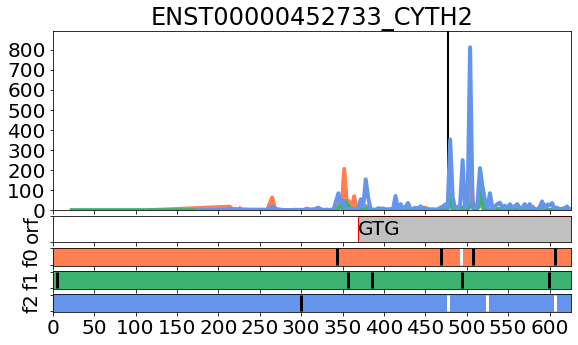

In [177]:
gene = 'CYTH2'

tr_id = R_Set[R_Set['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='DHFR', font1=20, font2=24)

In [178]:
start_of_ext =  int(R_Set[R_Set['gene'] == gene].iloc[0].pos_of_codon)
codon = R_Set[R_Set['gene'] == gene].iloc[0].codon
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
                                                                               start_of_ext, 
                                                                               end_of_CDS,
                                                                               codon
                                                                               ))

print (R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
       R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

tr_id: ENST00000452733; start of extension: 368; end of CDS: 1676; start codon: GTG
chr19:48469334-48469507 +


In [179]:
gene

'CYTH2'

### Cyth2 mouse 

In [258]:
gene_m = 'Cyth2'

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].tr_id)
print (346, cds_stop)

# expect ATA 

Cyth2
ENSMUST00000107729.9
346 1395


In [259]:
transcript_seq[87:1395]

'GTGGCTCCTGGGGCGTTTGAGCGGGCTCACTCGAGCCCGCGGGCCGACGCGGACGCAGGCCCAGCCGGCGGAACCGCCCCGGACTCCCCGCGGGCCTTCCTAGCCGCCATGGAGGACGGTGTCTACGAGCCCCCAGACTTGACTCCAGAGGAGCGCATGGAGTTGGAGAACATCCGGCGGCGCAAGCAGGAGCTGCTGGTGGAGATCCAGCGCCTGCGAGAAGAGCTAAGTGAAGCTATGAGCGAGGTGGAGGGTCTGGAGGCCAATGAGGGCAGTAAGACCTTGCAGCGGAACCGGAAGATGGCAATGGGCAGGAAGAAATTCAACATGGACCCCAAAAAGGGGATCCAATTCTTGGTGGAGCATGAACTTCTGCAGAACACGCCTGAGGAAATTGCCCGCTTCCTGTACAAGGGCGAGGGGCTGAACAAGACAGCCATTGGGGACTACCTAGGGGAAAGGGAAGAGCTGAACCTGTCTGTGCTCCATGCTTTTGTGGATCTCCATGAGTTCACCGACCTCAACCTGGTGCAGGCCCTCCGGCAATTCCTATGGAGCTTTCGCCTCCCTGGAGAGGCTCAGAAAATTGATCGAATGATGGAGGCCTTTGCCCAGAGATACTGCTTATGCAACCCTGGGGTCTTCCAGTCTACAGACACCTGCTACGTGTTGTCCTTTGCCGTGATCATGCTGAACACCAGCCTTCACAATCCCAATGTCAGGGACAAGCCGGGCCTGGAGCGCTTTGTGGCCATGAACCGGGGCATCAACGAGGGTGGGGATCTGCCTGAGGATCTTCTCAGGAACCTCTACGACAGCATCCGGAACGAGCCCTTCAAAATCCCAGAGGATGATGGGAATGATCTCACCCACACCTTCTTCAACCCAGACCGAGAGGGCTGGCTCCTAAAGCTGGGGGGCCGGGTGAAGACTTGGAAGCGGCGCTGGTTCATCCTTACAGACAACTGCCTCTACTACTTTGAATACACTACGGACAAG

In [260]:
transcript_seq[60:1395]

'CTGAGGACGGGCGCTGAGGAGGCGGCGGTGGCTCCTGGGGCGTTTGAGCGGGCTCACTCGAGCCCGCGGGCCGACGCGGACGCAGGCCCAGCCGGCGGAACCGCCCCGGACTCCCCGCGGGCCTTCCTAGCCGCCATGGAGGACGGTGTCTACGAGCCCCCAGACTTGACTCCAGAGGAGCGCATGGAGTTGGAGAACATCCGGCGGCGCAAGCAGGAGCTGCTGGTGGAGATCCAGCGCCTGCGAGAAGAGCTAAGTGAAGCTATGAGCGAGGTGGAGGGTCTGGAGGCCAATGAGGGCAGTAAGACCTTGCAGCGGAACCGGAAGATGGCAATGGGCAGGAAGAAATTCAACATGGACCCCAAAAAGGGGATCCAATTCTTGGTGGAGCATGAACTTCTGCAGAACACGCCTGAGGAAATTGCCCGCTTCCTGTACAAGGGCGAGGGGCTGAACAAGACAGCCATTGGGGACTACCTAGGGGAAAGGGAAGAGCTGAACCTGTCTGTGCTCCATGCTTTTGTGGATCTCCATGAGTTCACCGACCTCAACCTGGTGCAGGCCCTCCGGCAATTCCTATGGAGCTTTCGCCTCCCTGGAGAGGCTCAGAAAATTGATCGAATGATGGAGGCCTTTGCCCAGAGATACTGCTTATGCAACCCTGGGGTCTTCCAGTCTACAGACACCTGCTACGTGTTGTCCTTTGCCGTGATCATGCTGAACACCAGCCTTCACAATCCCAATGTCAGGGACAAGCCGGGCCTGGAGCGCTTTGTGGCCATGAACCGGGGCATCAACGAGGGTGGGGATCTGCCTGAGGATCTTCTCAGGAACCTCTACGACAGCATCCGGAACGAGCCCTTCAAAATCCCAGAGGATGATGGGAATGATCTCACCCACACCTTCTTCAACCCAGACCGAGAGGGCTGGCTCCTAAAGCTGGGGGGCCGGGTGAAGACTTGGAAGCGGCGCTGGTTCATCCTTACAGACAACTGCCTC

# 6 genes from PhyloSET and have rank between 500 and 1000

TNFAIP1, PELI2, IFFO2, VANGL2, WWC3, USP27X

# TNFAIP1

1285
0


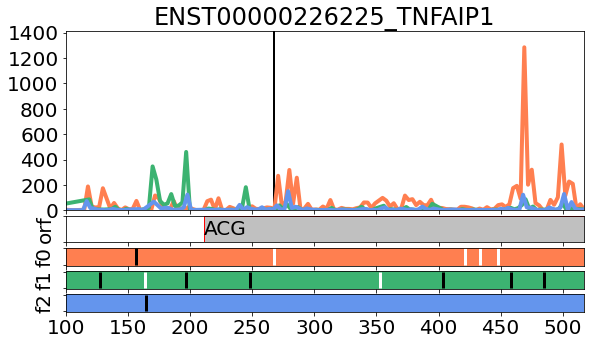

In [199]:
gene = 'TNFAIP1'

tr_id = P_Set[P_Set['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [100, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='DHFR', font1=20, font2=24)

In [203]:
start_of_ext =  int(P_Set[P_Set['gene'] == gene].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) - 1
codon = P_Set[P_Set['gene'] == gene].iloc[0].Riboseq_Summary.split(';')[0]
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
                                                                               start_of_ext, 
                                                                               end_of_CDS,
                                                                               codon
                                                                               ))

print (P_Set[P_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
       P_Set[P_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

tr_id: ENST00000226225; start of extension: 210; end of CDS: 1218; start codon: ACG
chr17:28339414-28339521 +


### TNFAIP1 mouse 

In [220]:
gene_m = 'Tnfaip1'

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].tr_id)
print (346, cds_stop)

# expect ATA 

Tnfaip1
ENSMUST00000017759.8
346 1265


# PELI2

1137
0


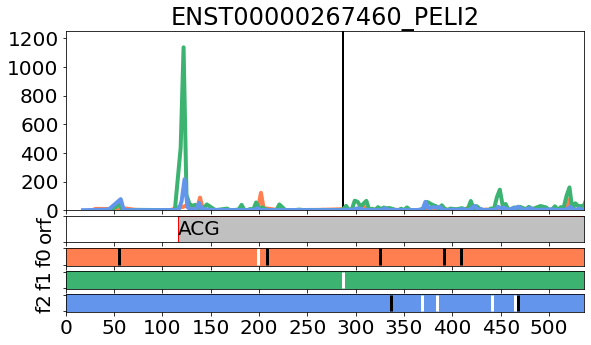

In [23]:
gene = 'PELI2'

tr_id = P_Set[P_Set['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='DHFR', font1=20, font2=24)

In [24]:
start_of_ext =  int(P_Set[P_Set['gene'] == gene].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) - 1
codon = P_Set[P_Set['gene'] == gene].iloc[0].Riboseq_Summary.split(';')[0]
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
                                                                               start_of_ext, 
                                                                               end_of_CDS,
                                                                               codon
                                                                               ))

print (P_Set[P_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
       P_Set[P_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

tr_id: ENST00000267460; start of extension: 115; end of CDS: 1549; start codon: ACG
chr14:56118376-56118660 +


In [25]:
tr_seq[115:1549]

'ACGACGGAGCAGCAGCGGGACTGGCCGCCCCGCGCCCCCTTCGCCGCCGTGCCCTTCCCCGGCGCGCTCACCCCGTTCTCGGGATGGGATTGTAGCGGCGGCGCGGACTCGGCGGGGATCGCGGCGGAGGCGGCGGCGTCGGCGGCGGCGTCGGCGGCCGAGCGGGGCTCCATGTTTTCCCCTGGCCAGGAGGAACACTGCGCCCCCAATAAGGAGCCAGTGAAATACGGGGAGCTGGTGGTGCTCGGGTACAATGGTGCTTTACCCAATGGAGATAGAGGACGGAGGAAAAGTAGATTTGCCCTCTACAAGCGGCCCAAGGCAAATGGTGTCAAACCCAGCACCGTCCATGTGATATCCACGCCCCAGGCATCCAAGGCTATCAGCTGCAAAGGTCAACACAGTATATCCTACACTTTGTCAAGGAATCAGACTGTGGTGGTGGAGTACACACATGATAAGGATACGGATATGTTTCAGGTGGGCAGATCAACAGAAAGCCCTATCGACTTCGTTGTCACAGACACGATTTCTGGCAGCCAGAACACGGACGAAGCCCAGATCACACAGAGCACCATATCCAGGTTCGCCTGCAGGATCGTGTGCGACAGGAATGAACCTTACACAGCACGGATATTCGCCGCCGGATTTGACTCTTCCAAAAACATATTTCTTGGAGAAAAGGCAGCAAAGTGGAAAAACCCCGACGGCCACATGGATGGGCTCACTACTAATGGCGTCCTGGTGATGCATCCACGAGGGGGCTTCACCGAGGAGTCCCAGCCCGGGGTCTGGCGCGAGATCTCTGTCTGTGGAGATGTGTACACCTTGCGAGAAACCAGGTCGGCCCAGCAACGAGGAAAGCTGGTGGAAAGTGAGACCAACGTCCTGCAGGACGGCTCCCTCATTGACCTGTGTGGGGCCACTCTCCTCTGGAGAACAGCAGATGGGCTTTTTCATACTCCAACTCAGAAGCACATAGAAGCCCTCCGGCAGGAG

### Peli2

In [34]:
gene_m = 'Peli2'

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].tr_id)
print (346, cds_stop)

# expect ATA 

Peli2
ENSMUST00000073150.4
346 1548


In [35]:
transcript_seq[129:1548]

'ACGACGGAGCAGCCGCGGGACTGGCCGCCCAGCGCCCCGTTCGCCGCCGTGCCGTTCCCCGGCGCGCTCACCCCGTTTTCGGGATGGGAGTGTAGTGGCGGCGCGGACTCGGCGGGGATCGCGGCGGAGGCGGCAGCGGCGGCGGCCGAGCGCGGCTCCATGTTTTCCCCGGGCCAGGAGGAACCCAGCGCCCCCAACAAGGAGCCGGTGAAATACGGGGAGCTGGTGGTCCTGGGGTACAATGGTGCTTTACCTAATGGTGACAGGGGCAGGAGGAAAAGCAGATTTGCCCTCTATAAGCGGACCTACGCCAGTGGTGTCAAACCCAGCACAATCCACATGGTCTCCACACCACAGGCGTCCAAGGCCATCAGCTCCAGAGGACATCACAGCATATCGTACACGTTGTCACGGAGCCAGACGGTAGTGGTGGAGTACACACACGATAAAGACACAGACATGTTTCAGGTGGGCAGGTCAACAGAAAGCCCCATTGACTTCGTGGTCACAGACACGGTTTCCGGCGGTCAGAACGAAGATGCCCAGATCACACAGAGCACCATCTCTAGGTTCGCATGCAGGATCGTGTGTGACAGGAACGAGCCATACACAGCACGCATATTCGCGGCAGGATTCGATTCTTCCAAAAATATCTTTCTTGGAGAGAAAGCAGCAAAATGGAAAAACCCTGATGGACACATGGATGGACTCACTACCAACGGTGTCCTGGTGATGCACCCGCAAGGAGGCTTCACCGAGGAATCCCAGCCTGGAGTCTGGAGAGAGATCTCTGTCTGTGGGGATGTATACACCTTGCGAGAGACCAGGTCGGCCCAGCAGAGGGGAAAGCTGGTGGAAAGTGAGACCAACGTCCTGCAAGACGGCTCCCTCATTGACCTGTGTGGGGCCACTCTCCTCTGGAGAACCGCAGATGGCCTTTTTCACGCTCCTACTCAGAAGCACATAGAAGCCCTCCGGCAGGAGATCAATGCAGCCCGA

# IFFO2

360
0


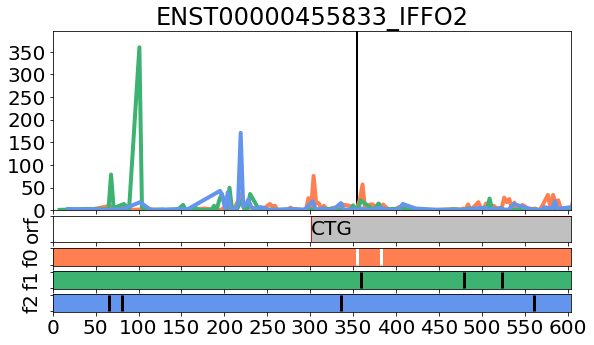

In [211]:
gene = 'IFFO2'

tr_id = P_Set[P_Set['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =50, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='DHFR', font1=20, font2=24)

In [212]:
start_of_ext =  int(P_Set[P_Set['gene'] == gene].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) - 1
codon = P_Set[P_Set['gene'] == gene].iloc[0].Riboseq_Summary.split(';')[0]
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
                                                                               start_of_ext, 
                                                                               end_of_CDS,
                                                                               codon
                                                                               ))

print (P_Set[P_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
       P_Set[P_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

tr_id: ENST00000455833; start of extension: 300; end of CDS: 1908; start codon: CTG
chr1:18956333-18956686 -


In [213]:
tr_seq[300:1908]

'CTGGAGCCGCACCTGGAGCCGCGGGCCCGGGGCCCTGAGCCGCGCAGCCGGCGCATGGTGAACTCGCTGCTGTTCGGGGAGATGGCCTTGGCCTTCGGCTGCCCGCCGGGCGGCGGCGGCGGGGGCTGCCCTGGCGGGGGCGGCGGCGGCGGCGGGGCAGGGCCGGGTCCGTCGCCGGTGACGGCGGCGCTGCGGGACGACCTGGGCTCCAACATCCACCTCTTGAAGGGGCTCAACGTGCGCTTCCGCTGCTTCCTGGCTAAGGTGCACGAGCTGGAGCGGCGCAACCGGCTGCTGGAGAAGCAGCTGGAGCAGCAGCAGAGCGAGCGCGAGCGGCGGCTGCGCTACAAGACCTTCTCCCGCGAGCAGGCCGTGCAGACCGGGCCCGAGTTGCTGCGGCCCCCGGCGCCCGGCGGCGGGCACGGCCTCAGCAGTGGCGCGGCGGCCGGCGCCAACGCCAATGCCGTGGCCCTGGGCGGCCTGCCCCCCGGCGGCGGCTCGCACCCGCAGCACTACGGCCGCCTGCCCGGGACCATCTGGAGCTACACGCAGGTGCGGCGCACGGGCGGCGGCGGCGTGGAGACCGTGCAGGGCCCCGGCGTGTCGTGGGTGCACCCCGACGGCGTGGGCGTGCAGATCGACACCATCACGCCGGAGATCCGCGCGCTCTACAACGTGCTGGCCAAGGTGAAGCGCGAGCGCGACGAGTATAAGCGGAGGTGGGAGGAGGAGCTCGCCAAGCGCATGAACCTTCAGACCATGGTGGACACGCTGCAGGAGGCAGCACAGGAGGCTGATGCCATCCAGGAGGAGATGAATGAGAAGATCGAGCGGCTCAAGGCCGAGCTGGTGGTGTTTAAGGGGCTTATGAGTGACCCCATGACAGACCTGGACACAAAGATCCAAGAAAAGGCCATGAAGGTGGACATGGACATCTGCCGCCGAATCGATATCACGGCCAAGCTGTGCGATGTCGCACAGCAGCGGAACTCAGAAGAC

### Iffo2 mouse 

In [40]:
gene_m = 'Iffo2'

i = 2

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[i].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[i].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[i].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[i].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[i].tr_id)
print (346, cds_stop)

# expect ATA 

Iffo2
ENSMUST00000174078.1
346 1767


In [39]:
meta_mice14[meta_mice14['gene'] == gene_m]

,tr_id,gene,gene_tr,transcript_seq,5UTR_start_seq,CDS_start,cds_seq,cds_start_codon,cds_stop_codon,cds_start_pos,cds_stop_pos,utr5_start,utr5_end,record_id,tr_id_len
15054,ENSMUST00000123827.8,Iffo2,Iffo2-202,CAAGCCAGTAAAGAACATCCCTCCATGGCCTCTGCATCGGCTCCTG...,CAAGCCAGTAAAGAACATCCCTCCATGGCCTCTGCATCGGCTCCTG...,CGC,ATGAACCTTCAGACCATGGTGGACACGCTGCAGGAGGCGGCGCAAG...,ATG,TGA,523,1387,0,523,ENSMUST00000123827.8|ENSMUSG00000041025.15|OTT...,2036
15055,ENSMUST00000040023.15,Iffo2,Iffo2-201,AGGTATCTTCTCCCTCGTGGCCATAGGTCAACAAATGTGACACCGT...,AGGTATCTTCTCCCTCGTGGCCATAGGTCAACAAATGTGACACCGT...,CGC,ATGAACCTTCAGACCATGGTGGACACGCTGCAGGAGGCGGCGCAAG...,ATG,TGA,417,1281,0,417,ENSMUST00000040023.15|ENSMUSG00000041025.15|OT...,5227
15056,ENSMUST00000174078.1,Iffo2,Iffo2-203,AGTCGCGGCGCAGGCACCGGACCCCTCACCAGCCCCACGCAGCCAC...,AGTCGCGGCGCAGGCACCGGACCCCTCACCAGCCCCACGCAGCCAC...,CGC,ATGGTTAACTCGCTGCTGTTCGGAGAGATGGCCTTGGCCTTCGGCT...,ATG,TGA,228,1767,0,228,ENSMUST00000174078.1|ENSMUSG00000041025.15|OTT...,5716


In [41]:
transcript_seq[174:1767]

'CTGGAGCCGCATCTGGAGCCACGGGCCCGGGGCCCTGAGCCACGCAGCCGGCGCATGGTTAACTCGCTGCTGTTCGGAGAGATGGCCTTGGCCTTCGGCTGCCCGCCGGGGGGCGGCGGCTGCGCAGGCGGCGGCGGGGGTGGCGGGGCCGGGCCGGGGCCCTCGCCCGTAACGGCGGCGCTGCGGGACGATCTGGGTTCCAACATCCACCTCCTCAAGGGGCTCAACGTGCGTTTCCGCTGCTTCTTGGCCAAGGTGCACGAGCTGGAGCGGCGCAACCGGCTCCTGGAGAAACAGCTGGAGCAGCAGCAGAGCGAGCGCGATCGGCGGCTGCGCTACAAGACCTTCTCCCGCGAGCAGGCCGTGCAGACCGGGCCCGAGCTGCTGCGGCCGTCGGCTGCGGGAAGCGGGCAGGCCCTCGGCGCGGCCACCGGCGTCAACGCCAACGCGGTGGCCCTGGGCGGCCTGCCCCCCGGCGGCGGCTCGCACCCGCAGCACTACGGTCGCCTGCCCGGGACCATCTGGAGCTACACGCAGGTGCGGCGCACGGGAGGCGGTGGCGTGGAGACTGTGCAGGGCCCCGGCGTGTCGTGGGTACACCCGGACGGCGTAGGCGTGCAGATCGACACCATCACGCCAGAGATCCGCGCTCTCTACAACGTGCTGGCCAAGGTGAAGCGCGAGCGTGACGAGTACAAACGGAGGTGGGAGGAGGAACTGGCCAAACGCATGAACCTTCAGACCATGGTGGACACGCTGCAGGAGGCGGCGCAAGAAGCCGAGGCTATCCAGGAGGAGATGAACGAGAAGATTGAGCGGCTCAAGGCCGAGCTGGTGGTGTTCAAAGGGCTCATGAGTGACCCCATGACAGACCTGGACACAAAGATCCAAGAAAAGGCTATGAAGGTGGACATGGACATCTGCCGCCGAATCGATATCACGGCTAAGCTGTGTGATGTCGCACAGCAGAGGAACTCAGAAGACGTGTCCAAGATCTTC

# WWC3

59
0


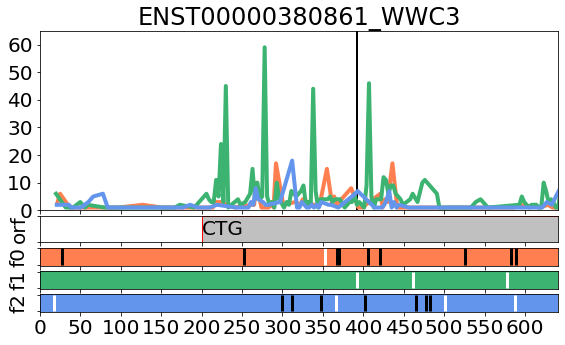

In [215]:
gene = 'WWC3'

tr_id = P_Set[P_Set['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='DHFR', font1=20, font2=24)

In [216]:
start_of_ext =  int(P_Set[P_Set['gene'] == gene].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) - 1
codon = P_Set[P_Set['gene'] == gene].iloc[0].Riboseq_Summary.split(';')[0]
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
                                                                               start_of_ext, 
                                                                               end_of_CDS,
                                                                               codon
                                                                               ))

print (P_Set[P_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
       P_Set[P_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

tr_id: ENST00000380861; start of extension: 199; end of CDS: 3670; start codon: CTG
chrX:10015563-10015858+chrX:10063445-10063538 +


In [217]:
tr_seq[199:]

'CTGCCCGCCGGCTGGGAGGAGGCGCGAGACTACGACGGTCGCGTCTTTTACATTGACCACAACACGCGCCAGACGTCGTGGATCGACCCCCGCGACCGGATAACAAAGCCATTGACCTTTGCCGATTGTGTTGGGGACGAACTTCCTTTAGGATGGGAAACCGTATATGATAAACAAATTGGAGTTTATTACATGGACCACATAAATAAACTTACCCAGATTGAGGATCCAAGAGAACAGTGGAGGCGAGAGCAAGAGCGCATGTTGAAGGAATATTTAATTGTAGCTCAGGAGGCTCTCAATGCCAAGAAAGAAATCTACCAGATTAAGCAGCAGCGGTTCGAGCTGGCCCAGGAGGAATACCAGCAGCTGCACAAAATGTGTGAGGATGACAGCCGCTCGTACGCCAGCTCATTCTCTGGATATTCAACAAATACAAAGTATGACCCACACCAAATTAAAGCAGAAATAGCAAGTCGTCGGGATAGGCTTTCCAGATTAAAACGAGAGCTGACCCAGATGAAGCAGGAACTGCAGTACAAAGAAAAGGGGGTGGAGACCCTGCAAGAGATTGATCGGAAGATGTCAAGTACTCACACCAGCTACAAACTGGATGAGGCGCAGGCTATCATGAGTGAGCTCCGGACCATCAAGAAGGCCATTTGCACAGGCGAGAAGGAGAGGCGGGACCTGATGCATAGCCTGGCCAAGCTGACCGATAGCTTCAAGAACAGCTGCTCCGTTACCGACTCTCTAGTGGACTTCCCTCACCATGTAGGCGTGCCTGGCGATGCTGGTGTACCCCAGCAGTTCTGCGATGCCGGCTCCCAGACTGATATCATCGGGGAGTTTGTCTTTGATGATAAAACAAGACTTGTAGACCGAGTCAGACTTAATTGGCAATATGAAGAAGCCAGAAAGAGAGTCGCCAACATCCAGCAGCAGCTGGCCCGGCTTGACAATGAGTCCTGGCCAAGCACGGCCGAGGCTGACAGGGAC

### wwc3 mouse 

In [30]:
meta_mice14[meta_mice14['gene'].str.contains('Ww')].gene.nunique()

6

In [224]:
gene_m = 'Wwc3'

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].tr_id)
print (346, cds_stop)

# expect ATA 

IndexError: single positional indexer is out-of-bounds

# USP27X

110
0


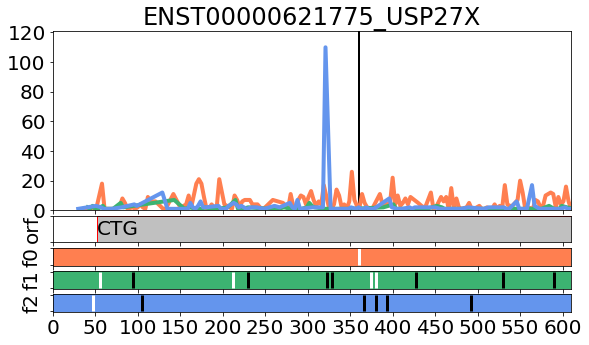

In [219]:
gene = 'USP27X'

tr_id = P_Set[P_Set['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =20, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='DHFR', font1=20, font2=24)

In [220]:
start_of_ext =  int(P_Set[P_Set['gene'] == gene].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) - 1
codon = P_Set[P_Set['gene'] == gene].iloc[0].Riboseq_Summary.split(';')[0]
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
                                                                               start_of_ext, 
                                                                               end_of_CDS,
                                                                               codon
                                                                               ))

print (P_Set[P_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
       P_Set[P_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

tr_id: ENST00000621775; start of extension: 51; end of CDS: 1677; start codon: CTG
chrX:49879948-49880307 +


In [221]:
tr_seq[51:100]

'CTGGATGTGGATTTTGCCGTGGGGCCACCAGGCTGTTCTCACGTGAACA'

### USP27X mouse 

In [31]:
gene_m = 'Usp27x'

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].tr_id)
print (346, cds_stop)

# expect ATA 

Usp27x
ENSMUST00000178293.7
346 2282


In [32]:
transcript_seq[656:2282]

'CTGGATGTGGATTTTGCTGTGGGGCCACCAGGTTGTTCCCACGTGAACAGCTTTAAGGTGGGAGAGAACTGGAGGCAGGAATTGCGGGTTATCTACCAGTGCTTCGTGTGGTGTGGAACCCCAGAGACCAGGAAAAGCAAGGCAAAGTCGTGCGTCTGCCATGTGTGTGGCACCCATTTAAACAGACTCCACTCTTGCCTTTCCTGCGTCTTCTTTGGCTGCTTCACAGAGAAACACATCCACGAGCACGCTGAGACAAAACAGCACAACTTAGCGGTAGATCTTTATTATGGAGGCATATACTGCTTCATGTGTAAAGACTATGTGTATGACATAGACATTGAGCAAATTGCCAAAGAAGAGCAAGGAGAAGCCTTGAAATTACAAGCGTCCACCTCGACAGAGGTTTCTCAGCAACAGTGTTCAGTGCCGGGACTTGGGGAGAAATATCCCACCTGGGAAACGACCAAACCTGAACTAGAACTTCTGGGGCACAACCCACGGAGAAGAAGGATCGCCTCCAGCTTTACCATCGGCTTACGAGGACTAATTAATCTTGGCAACACGTGTTTTATGAACTGCATTGTCCAGGCCTTGACCCACACTCCAATACTGAGAGATTTCTTTCTCTCTGACAGGCACCGGTGTGAAATGCCCAGCCCTGAGTTGTGTCTGGTCTGTGAGATGTCGTCGCTCTTTCGGGAGCTGTATTCTGGAAACCCATCTCCTCATGTGCCCTATAAGTTACTGCACCTGGTGTGGATACACGCTCGTCATCTAGCAGGGTACAGGCAGCAGGATGCCCACGAGTTCCTCATCGCTGCGCTAGATGTCCTGCATAGGCACTGCAAAGGTGACGATGTTGGCAAGGTGGCCAGCAACCCCAACCACTGTAACTGCATCATAGACCAAATCTTCACAGGTGGCCTGCAGTCCGATGTCACCTGTCAAGCCTGCCATGGTGTCTCCACCACTATAGACCCATGCTGGGACATTAGT

# SNRNP25  riboset

In [228]:
meta[meta['gene'] == gene].iloc[0].Riboseq_Summary

nan

1138
0


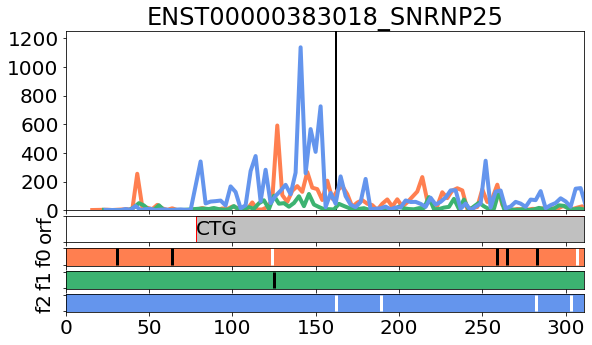

In [241]:
gene = 'SNRNP25'

tr_id = 'ENST00000383018' #meta[meta['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/SNRNP25_ENST00000383018_unamb.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='DHFR', font1=20, font2=24)

In [239]:
meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary

'CTG; 78-162; Rank: 99; cov: 91.3'

In [243]:
start_of_ext =  int(R_Set[R_Set['gene'] == gene].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) - 1
codon = R_Set[R_Set['gene'] == gene].iloc[0].Riboseq_Summary.split(';')[0]
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
                                                                               start_of_ext, 
                                                                               end_of_CDS,
                                                                               codon
                                                                               ))

print (R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
       R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

tr_id: ENST00000383018; start of extension: 77; end of CDS: 560; start codon: CTG
chr16:53831-53989 +


In [244]:
tr_seq[77:560]

'CTGGAGGAGACGGAGGCCGCGGGTGGGCCCGAGGCGCAAGAGGAAGATGAGGACGAAGAAGAGGCGCTGCCGCACTCCGAGGCCATGGACGTGTTCCAGGAGGGTCTGGCTATGGTGGTGCAGGACCCGCTGCTCTGCGATCTGCCGATCCAGGTTACTCTGGAAGAAGTCAACTCCCAAATAGCCCTAGAATACGGCCAGGCAATGACGGTCCGAGTGTGCAAGATGGATGGAGAAGTAATGCCCGTGGTTGTAGTGCAGAGTGCCACAGTCCTGGACCTGAAGAAGGCCATCCAGAGATACGTGCAGCTCAAGCAGGAGCGTGAAGGGGGCATTCAGCACATCAGCTGGTCCTACGTGTGGAGGACGTACCATCTGACCTCTGCAGGAGAGAAACTCACGGAAGACAGAAAGAAGCTCCGAGACTACGGCATCCGGAATCGAGACGAGGTTTCCTTCATCAAAAAGCTGAGGCAAAAGTGA'

In [245]:
gene

'SNRNP25'

### SNRNP25 mouse 

In [36]:
gene_m = 'Snrnp25'

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].tr_id)
print (346, cds_stop)

# expect ATA 

Snrnp25
ENSMUST00000039601.9
346 579


In [37]:
transcript_seq[96:579]

'CTGGAGGACCCGGAGGCTGAGGATCGGCCGGAGGTGCCGGAGGACGACGAGGATGATGAGGAGACATTGCCCCATTCCGAGGCTGTGGACGTGTTCCAAGAAGGTCTCGCCATGGTGGTGCAAGACCCGCTGCTCTGCGACCTTCCGATCCAGGTTACTCTAGAAGAGGTCAACTCCCAGATTGCACTGGAATATGGCCAGGCGATGACTGTCCGTGTGTGCAAGATGGATGGAGAGGTAATGCCTGTGGTCGTCGTACAGAATGCCACGGTCCTGGACCTGAAGAAGGCTATCCAGAGATACGTGCAGCTCAAGCAGGAGCGGGAAGGCGGCGTTCAGCACATCAGCTGGTCCTATGTATGGCGGACATACCATCTGACCTCAGCTGGGGAGAAGCTCACAGAGGACAGGAAGAAGCTCAGAGATTATGGCATCCGGAACCGAGATGAGGTTTCCTTTATCAAGAAGCTTAGGCAAAAGTGA'

# SOX10

14
0


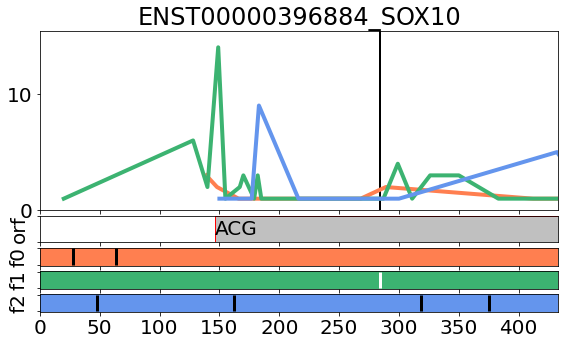

In [250]:
gene = 'SOX10'

tr_id = meta[meta['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

# SOX10_ENST00000396884_unamb.csv


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='DHFR', font1=20, font2=24)

In [247]:
meta[meta['gene'] == 'SOX10'].iloc[0]

tr_id                                                                          ENST00000396884.6
N_term_start                                                                                   0
N_term_end                                                                                   283
len                                                                                          283
N_term_start1                                                                                  1
N_term_end1                                                                                  283
len_codons                                                                                  94.0
gene                                                                                       SOX10
50len_flag                                                                                   133
global_coo_50_and_less                           chr22:37983785-37983868+chr22:37984339-37984404
strand                        

# R_Set 

In [255]:
R_Set['Rank'] = [int(x.split('Rank:')[1].split(';')[0]) for x in R_Set['Riboseq_Summary'].tolist()]

R_Set[0:2]

,tr_id,gene,N_term_start1,N_term_end1,len_codons,global_coo_50_and_less,strand,global_coo_primary,PhyloCSF120score,number_of_records,ovlp,Riboseq_Summary,Coverage_value_ext,Proteomics_count_ext,tag,transcript_type,CDS_ratio,pos_of_codon,codon,Rank
0,ENST00000379389.4,ISG15,1,151,50.0,chr1:1013424-1013573,+,chr1:1013424-1013573,-2443.9971,111,0;0;0,ATC; 98-152; Rank: 288; cov: 53.85,53.846154,0.0,"basic,appris_principal_1,CCDS",protein_coding,0.327240,97,ATC,288
1,ENST00000349431.10,UBE2J2,28,220,64.0,chr1:1273666-1273815,-,chr1:1273666-1273857,-1285.8186,78,0;0;0,ACG; 173-221; Rank: 328; cov: 90.91,90.909091,0.0,"basic,appris_principal_1,CCDS",protein_coding,0.762814,172,ACG,328


In [257]:
R_Set.sort_values(by='Rank')[0:10]

,tr_id,gene,N_term_start1,N_term_end1,len_codons,global_coo_50_and_less,strand,global_coo_primary,PhyloCSF120score,number_of_records,ovlp,Riboseq_Summary,Coverage_value_ext,Proteomics_count_ext,tag,transcript_type,CDS_ratio,pos_of_codon,codon,Rank
169,ENST00000379454.8,ASPH,50,188,46.0,chr8:61714372-61714509,-,chr8:61714372-61714509,-1473.5792,93,0;0;0,CTG; 144-189; Rank: 1; cov: 100.0,100.000000,0.000000,"basic,appris_principal_1,CCDS",protein_coding,1.645069,143,CTG,1
254,ENST00000216281.12,HSP90AA1,26,206,60.0,chr14:102086986-102087135,-,chr14:102086986-102087165,-1331.1851,63,0;0;0,GTG; 168-207; Rank: 2; cov: 100.0,100.000000,0.000000,"basic,appris_principal_1,CCDS",protein_coding,3.081078,167,GTG,2
315,ENST00000409753.7,HN1,145,286,47.0,chr17:75154398-75154538,-,chr17:75154398-75154538,-2973.9610,114,0;0;0,TTG; 242-287; Rank: 4; cov: 100.0,100.000000,0.000000,"basic,appris_principal_1,CCDS",protein_coding,0.588389,241,TTG,4
15,ENST00000321358.11,YBX1,1,139,46.0,chr1:42682428-42682565,+,chr1:42682428-42682565,-204.2880,107,0;0;0,CTG; 44-140; Rank: 5; cov: 85.19,85.185185,0.000000,"basic,appris_principal_1,CCDS",protein_coding,7.709763,43,CTG,5
123,ENST00000314940.6,HNRNPA0,241,310,23.0,chr5:137754067-137754135,-,chr5:137754067-137754135,27.8325,111,0;0;0,ATA; 248-311; Rank: 6; cov: 93.75,93.750000,30.692308,"basic,appris_principal_1,CCDS",protein_coding,0.838178,247,ATA,6
126,ENST00000252102.8,NDUFA2,46,202,52.0,chr5:140647584-140647733,-,chr5:140647584-140647739,-3318.6220,116,0;0;0,CTG; 173-203; Rank: 7; cov: 100.0,100.000000,0.000000,"basic,appris_principal_1,CCDS",protein_coding,0.728614,172,CTG,7
234,ENST00000014914.5,GPRC5A,758,890,44.0,chr12:12891540-12891664+chr12:12908243-12908249,+,chr12:12891540-12891664+chr12:12908243-12908249,-1804.6641,119,0;0;0,AAG; 855-891; Rank: 8; cov: 100.0,100.000000,0.000000,"basic,appris_principal_1,CCDS",protein_coding,1.388916,854,AAG,8
14,ENST00000357214.5,SFPQ,0,99,33.0,chr1:35193050-35193148,-,chr1:35193050-35193148,192.1951,115,0;0;0,GTG; 37-100; Rank: 9; cov: 81.25,81.250000,11.538462,"basic,appris_principal_1,CCDS",protein_coding,0.590000,36,GTG,9
129,ENST00000296930.9,NPM1,58,301,81.0,chr5:171387799-171387948,+,chr5:171387706-171387948,-2367.1162,112,0;0;0,CTG; 239-302; Rank: 10; cov: 68.75,68.750000,0.000000,"basic,appris_principal_1,CCDS",protein_coding,25.027984,238,CTG,10
318,ENST00000301634.11,TK1,5,239,78.0,chr17:78186995-78187144,-,chr17:78186995-78187228,-2213.6338,105,0;0;0,ACG; 195-240; Rank: 11; cov: 80.0,80.000000,0.000000,"basic,appris_principal_1,CCDS",protein_coding,0.542917,194,ACG,11


# ASPH

7726
0


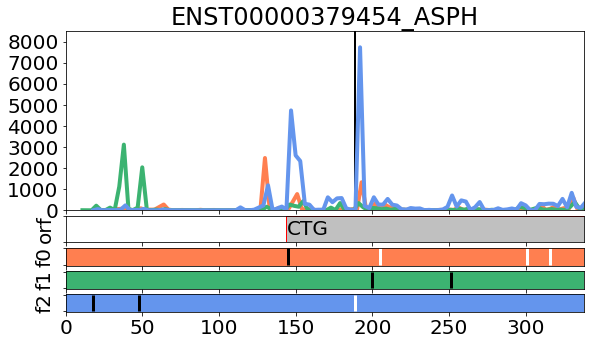

In [261]:
gene = R_Set.sort_values(by='Rank').iloc[0].gene

tr_id = R_Set.sort_values(by='Rank').iloc[0].tr_id.split('.')[0]

pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =1000, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='DHFR', font1=20, font2=24)


In [262]:
start_of_ext =  int(R_Set[R_Set['gene'] == gene].iloc[0].pos_of_codon)
codon = R_Set[R_Set['gene'] == gene].iloc[0].codon
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
                                                                               start_of_ext, 
                                                                               end_of_CDS,
                                                                               codon
                                                                               ))

print (R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
       R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

tr_id: ENST00000379454; start of extension: 143; end of CDS: 2465; start codon: CTG
chr8:61714372-61714509 -


### Asph mouse 

In [227]:
gene_m = 'Asph'

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].tr_id)
print (346, cds_stop)

# expect ATA 

Asph
ENSMUST00000078139.12
346 2478


# HSP90AA1

31734
0


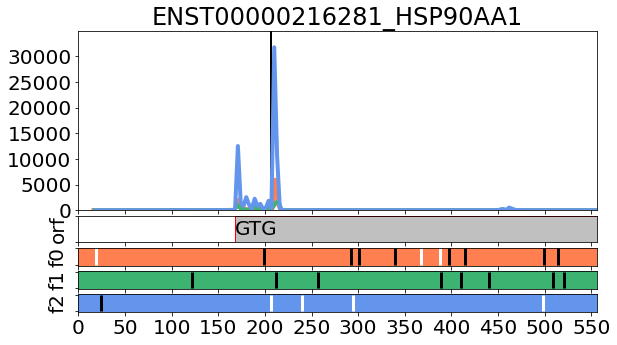

In [266]:
gene = R_Set.sort_values(by='Rank').iloc[1].gene

tr_id = R_Set.sort_values(by='Rank').iloc[1].tr_id.split('.')[0]

pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*7]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5000, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='DHFR', font1=20, font2=24)


In [268]:
start_of_ext =  int(R_Set[R_Set['gene'] == gene].iloc[0].pos_of_codon)
codon = R_Set[R_Set['gene'] == gene].iloc[0].codon
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
                                                                               start_of_ext, 
                                                                               end_of_CDS,
                                                                               codon
                                                                               ))

print (R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
       R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

tr_id: ENST00000216281; start of extension: 167; end of CDS: 2405; start codon: GTG
chr14:102086986-102087165 -


In [270]:
tr_seq[167:200]

'GTGGCTGTGCCGTTGGTCCTGTGCGGTCACTTA'

In [271]:
tr_seq[metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos:metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+4]

'ATGC'

### HSP90AA1 mouse 

In [228]:
gene_m = 'Hsp90aa1'

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].tr_id)
print (346, cds_stop)

# expect ATA 

Hsp90aa1
ENSMUST00000094361.10
346 2346


# HN1

9164
0


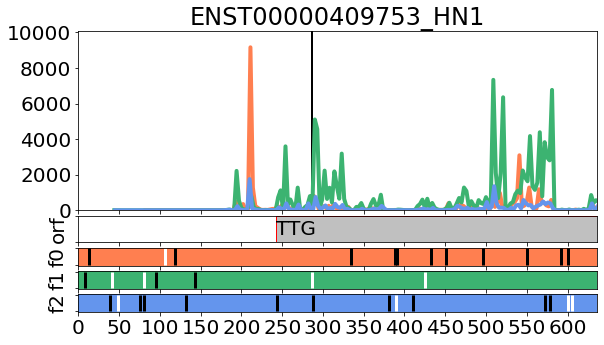

In [273]:
gene = R_Set.sort_values(by='Rank').iloc[2].gene

tr_id = R_Set.sort_values(by='Rank').iloc[2].tr_id.split('.')[0]

pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*7]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =2000, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='DHFR', font1=20, font2=24)


In [274]:
start_of_ext =  int(R_Set[R_Set['gene'] == gene].iloc[0].pos_of_codon)
codon = R_Set[R_Set['gene'] == gene].iloc[0].codon
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
                                                                               start_of_ext, 
                                                                               end_of_CDS,
                                                                               codon
                                                                               ))

print (R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
       R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

tr_id: ENST00000409753; start of extension: 241; end of CDS: 751; start codon: TTG
chr17:75154398-75154538 -


# YBX1

36921
0


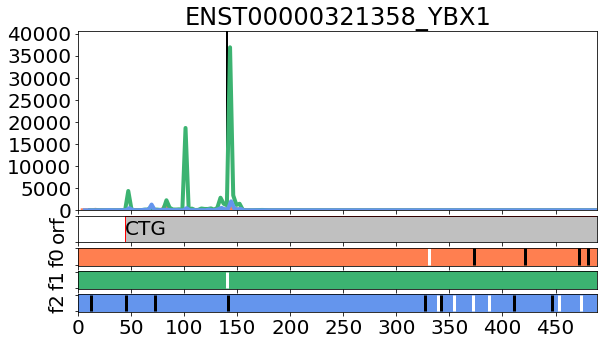

In [276]:
gene = R_Set.sort_values(by='Rank').iloc[3].gene

tr_id = R_Set.sort_values(by='Rank').iloc[3].tr_id.split('.')[0]

pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*7]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5000, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='DHFR', font1=20, font2=24)


In [277]:
start_of_ext =  int(R_Set[R_Set['gene'] == gene].iloc[0].pos_of_codon)
codon = R_Set[R_Set['gene'] == gene].iloc[0].codon
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
                                                                               start_of_ext, 
                                                                               end_of_CDS,
                                                                               codon
                                                                               ))

print (R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
       R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

tr_id: ENST00000321358; start of extension: 43; end of CDS: 1114; start codon: CTG
chr1:42682428-42682565 +


In [279]:
tr_seq[43:60]

'CTGAGCAGCCCCACCGC'

### Ybx1 mice 

In [229]:
gene_m = 'Ybx1'

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].tr_id)
print (346, cds_stop)

# expect ATA 

Ybx1
ENSMUST00000079644.12
346 1210


# HNRNPA0

9412
0


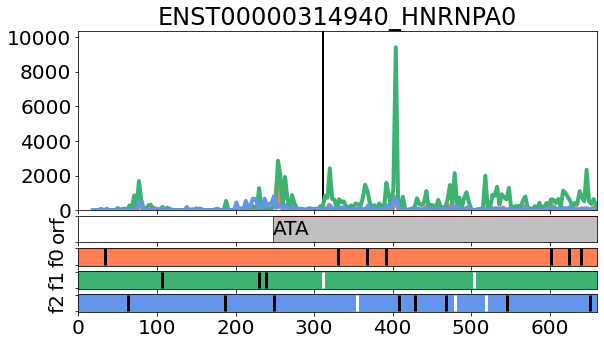

In [282]:
gene = R_Set.sort_values(by='Rank').iloc[4].gene

tr_id = R_Set.sort_values(by='Rank').iloc[4].tr_id.split('.')[0]

pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*7]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =2000, 
                             fraq = 100, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='DHFR', font1=20, font2=24)


### HNRNPA0 mouse 

In [230]:
gene_m = 'Hnrnpa0'

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].tr_id)
print (346, cds_stop)

# expect ATA 

Hnrnpa0
ENSMUST00000007980.6
346 1161


# NDUFA2

3027
0


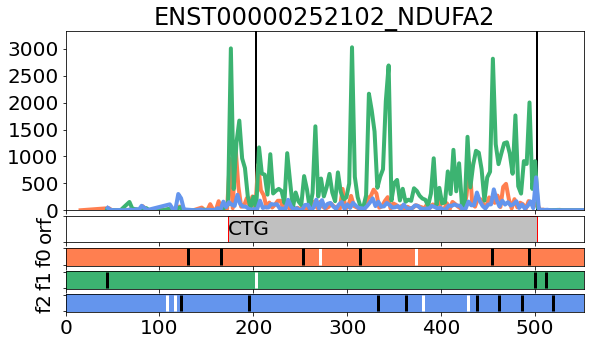

In [284]:
gene = R_Set.sort_values(by='Rank').iloc[5].gene

tr_id = R_Set.sort_values(by='Rank').iloc[5].tr_id.split('.')[0]

pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*7]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =500, 
                             fraq = 100, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='DHFR', font1=20, font2=24)


In [285]:
start_of_ext =  int(R_Set[R_Set['gene'] == gene].iloc[0].pos_of_codon)
codon = R_Set[R_Set['gene'] == gene].iloc[0].codon
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
                                                                               start_of_ext, 
                                                                               end_of_CDS,
                                                                               codon
                                                                               ))

print (R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
       R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

tr_id: ENST00000252102; start of extension: 172; end of CDS: 502; start codon: CTG
chr5:140647584-140647739 -


In [286]:
tr_seq[172:180]

'CTGGAATT'

In [287]:
gene

'NDUFA2'

### NDUFA2 mouse 

In [231]:
gene_m = 'Ndufa2'

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].tr_id)
print (346, cds_stop)

# expect ATA 

Ndufa2
ENSMUST00000014438.4
346 337


# Most likely exclusive

# STK38, ENST00000229812.7

1776
0


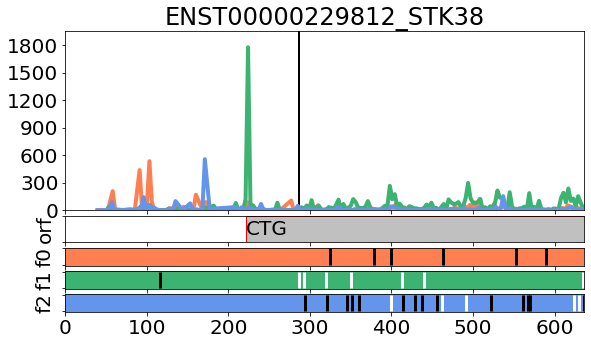

In [289]:
gene = 'STK38'

tr_id = 'ENST00000229812'

pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0]) 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*7]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =300, 
                             fraq = 100, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='DHFR', font1=20, font2=24)


In [290]:
start_of_ext =  int(R_Set[R_Set['gene'] == gene].iloc[0].pos_of_codon)
codon = R_Set[R_Set['gene'] == gene].iloc[0].codon
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
                                                                               start_of_ext, 
                                                                               end_of_CDS,
                                                                               codon
                                                                               ))

print (R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
       R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

tr_id: ENST00000229812; start of extension: 220; end of CDS: 1684; start codon: CTG
chr6:36540203-36540207+chr6:36547190-36547352 -


In [291]:
tr_seq[220:230]

'CTGGCCGAAG'

### STK38 mouse 

In [232]:
gene_m = 'Stk38'

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].tr_id)
print (346, cds_stop)

# expect ATA 

Stk38
ENSMUST00000009138.11
346 1627


# INSL4, ENST00000239316.4

1404
0


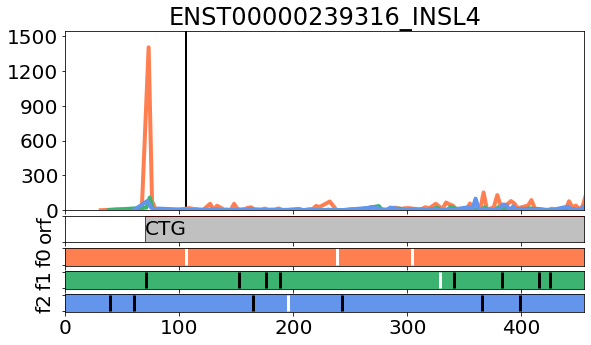

In [295]:
gene = 'INSL4'

tr_id = 'ENST00000239316'

pred_start = 'CTG'#meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = int(meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0])+3 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*7]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =300, 
                             fraq = 100, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='DHFR', font1=20, font2=24)


In [298]:
start_of_ext =  int(R_Set[R_Set['gene'] == gene].iloc[0].pos_of_codon)+3
codon = 'CTG' #R_Set[R_Set['gene'] == gene].iloc[0].codon
end_of_CDS = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq

print ('tr_id: %s; start of extension: %s; end of CDS: %s; start codon: %s' % (tr_id, 
                                                                               start_of_ext, 
                                                                               end_of_CDS,
                                                                               codon
                                                                               ))

print (R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].global_coo_primary, 
       R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].strand)

tr_id: ENST00000239316; start of extension: 69; end of CDS: 525; start codon: CTG
chr9:5231419-5231523 +


In [297]:
tr_seq[69:75]

'CTGAGA'

### Insl4 mouse 

In [236]:
R_Set_match[R_Set_match['gene_human'] == 'INSL4']

,gene_mouse,gene_human
17,None,INSL4


In [234]:
gene_m = 'Insl4'

transcript_seq = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].transcript_seq
cds_start = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_start_pos
cds_stop = meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].cds_stop_pos

print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].gene)
print ( meta_mice14[meta_mice14['gene'] == gene_m].iloc[0].tr_id)
print (346, cds_stop)

# expect ATA 

IndexError: single positional indexer is out-of-bounds